
# **Machine Learning Project : Bankruptcy Prediction**
**Authors:** Matthieu HANNA GERGUIS, Renaud de l'Epine, Ilian SEGOIN  
**Date:** November 2025

---

# **Project Plan**

| Section | Short Description | Technical Objective |
|--------|--------------------|-------------------------------|
| **Introduction** | Context: bankruptcy prediction on a highly imbalanced dataset.<br>Goal: minimize false negatives (missed bankruptcies). | Define the ML problem and project objective. |
| **I. Data Exploration & Importation** | Dataset dimensions, types, stats, distributions, zero analysis, variance study. | Understand the dataset and detect uninformative features. |
| **II. Data Cleaning & Feature Selection** | VarianceThreshold, correlation filtering, dynamic per-feature variance thresholds. | Reduce noise and keep only meaningful variables. |
| **III. Preprocessing** | Standardization + PCA (95% variance retained). | Normalize data and reduce dimensionality. |
| **IV. Stage 1 – Baseline Models** | Logistic Regression, Naive Bayes, Random Forest (with/without PCA). | Establish baseline predictive performance. |
| **V. Stage 2 – Imbalance Handling** | Undersampling, Random Oversampling, SMOTE + recall comparison. | Improve minority-class detection (bankruptcy). |
| **VI. Stage 3 – Final Model & Validation** | Final choice: Logistic Regression + Oversampling + PCA.<br>Validation with AUC/Recall and cross-validation. | Stabilize performance and validate the final model. |
| **VII. Conclusion: Our Best Model** | Summary of results, limitations (imbalance, information loss), and future improvements (XGBoost, CatBoost, calibration). | Deliver final insights and improvement directions. |


---

## **Introduction**

Bankruptcy prediction is a central problem in finance and risk management, as identifying companies at risk of failure allows investors, banks, and regulators to minimize financial losses and prevent systemic crises. Machine learning provides powerful tools for detecting non-linear patterns in financial indicators that traditional methods often fail to capture.

### **Context:**

Corporate bankruptcy events are rare but extremely costly. Missing a bankrupt company (false negative) can lead to major economic risks. This makes the prediction task both challenging and highly relevant for real-world applications.  
The dataset used in this project reflects this reality: the minority class (bankrupt companies) represents only around **3%** of all observations.

### **Dataset Origin:**

The dataset was originally collected from the **Taiwan Economic Journal (TEJ)** and contains financial records from **1999 to 2009**.  
Bankruptcy labels were assigned according to the official rules of the **Taiwan Stock Exchange**.

The dataset was first published on the **UCI Machine Learning Repository**, and a cleaned version is hosted on Kaggle:  
**https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction**

It contains:  
- **6,819 companies**  
- **95 financial features** (profitability ratios, liquidity ratios, leverage metrics, cash flow indicators, turnover rates, growth indicators, etc.)  
- **1 binary label**: *Bankrupt?* (0 = healthy, 1 = bankrupt)

### **Why This Problem Is Interesting ?**

- The dataset is **high-dimensional** (nearly 100 features)  
- The target class is **extremely imbalanced**  
- Many features are **strongly correlated or redundant**  
- The cost of misclassification is **very asymmetrical**  
- It represents a **real-world financial prediction challenge**

### **Project Objectives:**

- Build a **robust ML pipeline** for bankruptcy prediction  
- Reduce noise and redundancy through **feature selection**  
- Handle class imbalance using **resampling techniques**  
- Train and compare multiple models  
- Optimize the best model with a focus on **recall** (detecting bankrupt companies)  

---

## **I. Data Exploration & Importation**

This section focuses on importing the dataset and performing an initial exploration of its structure.  
The goal is to understand the dimensionality of the data, inspect the types of variables, detect potential anomalies, and identify early patterns that may influence preprocessing choices later in the project.

### **Objectives:**

- Load the dataset correctly from its source.  
- Inspect the number of rows and columns.  
- Examine data types (int, float) and check for consistency.  
- Detect binary variables and special patterns.  
- Generate descriptive statistics to understand distributions.  
- Analyze variance to identify variables with low information value.  

### **I.A Imported Libraries**


In [ ]:
# ================================
# Automatic dependency installation
# ================================

import sys
import subprocess

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

required_packages = [
    "numpy",
    "pandas",
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "imbalanced-learn",
    "xgboost",
    "catboost",
    "tensorflow",
    "keras-tuner"
]

for pkg in required_packages:
    try:
        __import__(pkg.replace("-", "_"))
    except ImportError:
        install(pkg)


In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    MinMaxScaler,
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import (
    LogisticRegression,
    LinearRegression,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
)
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    f_classif,
)

from sklearn.utils import resample

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    auc,
    recall_score,
    make_scorer,
    mean_squared_error,
    r2_score,
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall

import keras_tuner
from keras_tuner import RandomSearch


The following libraries are used for:
- **Data manipulation**: pandas, numpy  
- **Visualization**: matplotlib, seaborn  
- **Preprocessing**: StandardScaler, VarianceThreshold  
- **Modeling**: Logistic Regression, Random Forest, Naive Bayes, etc.  
- **Evaluation**: accuracy, recall, confusion matrix, ROC curve  
- **Oversampling techniques**: SMOTE, resampling  
- **Advanced models**: CatBoost, XGBoost, neural networks  

These imports provide all the tools necessary for exploration, cleaning, modeling, and evaluation throughout the project.

---


### **I.B Importation & Visualization of the Dataset**

In [2]:
df = pd.read_csv("data_clean.csv")

print("Dataset dimensions (rows, columns):", df.shape)
print("\nPreview of the first rows:")
df.head(10)


Dataset dimensions (rows, columns): (6819, 96)

Preview of the first rows:


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
5,1,0.388680,0.415177,0.419134,0.590171,0.590251,0.998758,0.796903,0.808771,0.303116,...,0.710420,0.005278,0.622605,0.590172,0.829939,0.285087,0.026675,0.564538,1,0.019534
6,0,0.390923,0.445704,0.436158,0.619950,0.619950,0.998993,0.797012,0.808960,0.302814,...,0.736619,0.018372,0.623655,0.619949,0.829980,0.292504,0.026622,0.564200,1,0.015663
7,0,0.508361,0.570922,0.559077,0.601738,0.601717,0.999009,0.797449,0.809362,0.303545,...,0.815350,0.010005,0.623843,0.601739,0.841459,0.278607,0.027031,0.566089,1,0.034889
8,0,0.488519,0.545137,0.543284,0.603612,0.603612,0.998961,0.797414,0.809338,0.303584,...,0.803647,0.000824,0.623977,0.603613,0.840487,0.276423,0.026891,0.565592,1,0.065826
9,0,0.495686,0.550916,0.542963,0.599209,0.599209,0.999001,0.797404,0.809320,0.303483,...,0.804195,0.005798,0.623865,0.599205,0.840688,0.279388,0.027243,0.566668,1,0.030801


The dataset is loaded using **pandas**, from the file path defined earlier.  
This data originates from the Taiwan Economic Journal (TEJ) and contains financial indicators for the years 1999–2009.


In [3]:
df.info() # all the columnns and their type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

We use `df.info()` to quickly verify the integrity of the dataset.  
This confirms that:

- The dataset contains **6,819 rows and 96 columns** (expected structure).  
- **No missing values** are present (all entries are non-null).  
- All features are **numerical** (`float64` and `int64`), which is ideal for ML models.

**Conclusion:**  
The dataset is clean and structurally consistent, no issues detected.

---




### 🧪  **I.C Data Exploration**

The goal of the *Data Exploration* phase is to understand the structure and basic properties of the dataset before applying any preprocessing or modeling steps.  
This stage allows us to:

- verify the consistency of variable types,  
- detect potential anomalies (missing values, binary indicators, ratio-like variables),  
- analyze the distribution of key features,  
- identify low-information or redundant columns early.

This initial analysis is essential for guiding later decisions regarding data cleaning, feature selection, and preprocessing.


<p align="center">• • •</p>


#### **C.1 Checking Variable Types**

In [4]:
df.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

This command lists all data types in the dataset.
We confirm that all columns are numerical (int64, float64), which simplifies preprocessing and model training.

<p align="center">• • •</p>


#### **C.2 Identifying Integer Columns**

In [5]:
colonnes_int = [col for col in df.columns if df[col].dtype == 'int64']
print(colonnes_int)

['Bankrupt?', ' Liability-Assets Flag', ' Net Income Flag']


Extracts all columns stored as integers.
These usually represent flags or binary indicators (including the target), helping us understand which variables behave like categorical features.

<p align="center">• • •</p>


#### **C.3 Detecting Binary Variables (exactly 2 unique values)**

In [6]:
binary_columns = [col for col in df.columns if df[col].nunique() == 2]
print(binary_columns)


['Bankrupt?', ' Liability-Assets Flag']


Identifies columns with only two unique values.
Useful to detect the target variable and other boolean features that influence class imbalance handling and model evaluation.

<p align="center">• • •</p>


#### **C.4 Detecting Features Ranging Between 0 and 1**

In [7]:
df.describe()


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


Provides summary statistics (min, max, mean, std, quartiles).
Confirms the dataset has no missing values and helps assess feature scale and distribution before cleaning.

<p align="center">• • •</p>


#### **C.5 Variance Computation**

In [8]:
variances = df.var()
variances_sorted = variances.sort_values(ascending=False)
print(variances_sorted)

Quick Asset Turnover Rate               1.139025e+19
Inventory Turnover Rate (times)         1.054929e+19
Operating Expense Rate                  1.048260e+19
Cash Turnover Rate                      8.635506e+18
Total Asset Growth Rate                 8.396768e+18
                                            ...     
Continuous Net Profit Growth Rate       1.012632e-04
Total Asset Return Growth Rate Ratio    9.281798e-05
Cash Flow to Sales                      8.726074e-05
Working capitcal Turnover Rate          8.027056e-05
Net Income Flag                         0.000000e+00
Length: 96, dtype: float64


This step computes the variance of each feature and sorts them from highest to lowest.  
It helps identify:
- informative features with high variance,  
- near-constant features with extremely low variance, which may not contribute to prediction.


<p align="center">• • •</p>

#### **C.6 Variance Summary**

In [9]:
summary = variances.describe()
print(summary)


count    9.600000e+01
mean     7.476444e+17
std      2.490529e+18
min      0.000000e+00
25%      1.930985e-04
50%      1.117676e-03
75%      2.772584e+14
max      1.139025e+19
dtype: float64


The statistical summary of variances provides global indicators (mean, quartiles, min/max).  
It helps assess:
- how spread variances are across features,  
- confirmation that many features have very low variance,  
- guidance for choosing an appropriate variance threshold.

<p align="center">• • •</p>

#### **C.7 Variance Bar Plot (Raw Scale)**

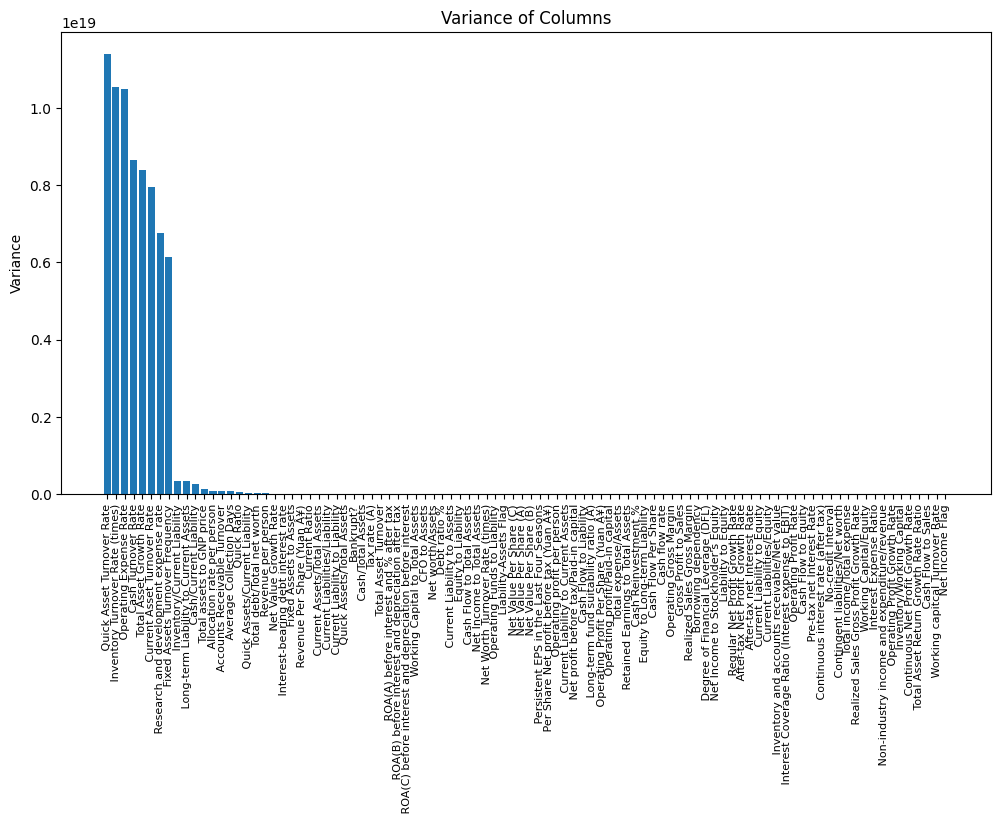

In [10]:
variances_sorted = variances.sort_values(ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(variances_sorted.index, variances_sorted.values)
plt.xticks(rotation=90, fontsize=8)
plt.ylabel('Variance')
plt.title('Variance of Columns')
plt.show()


This plot shows the raw variance of each feature.  
Due to large scale differences, many features appear nearly flat.  
This indicates the raw scale is not suitable for meaningful visual comparison.


<p align="center">• • •</p>

#### **C.8 Variance Bar Plot (Log Scale)**

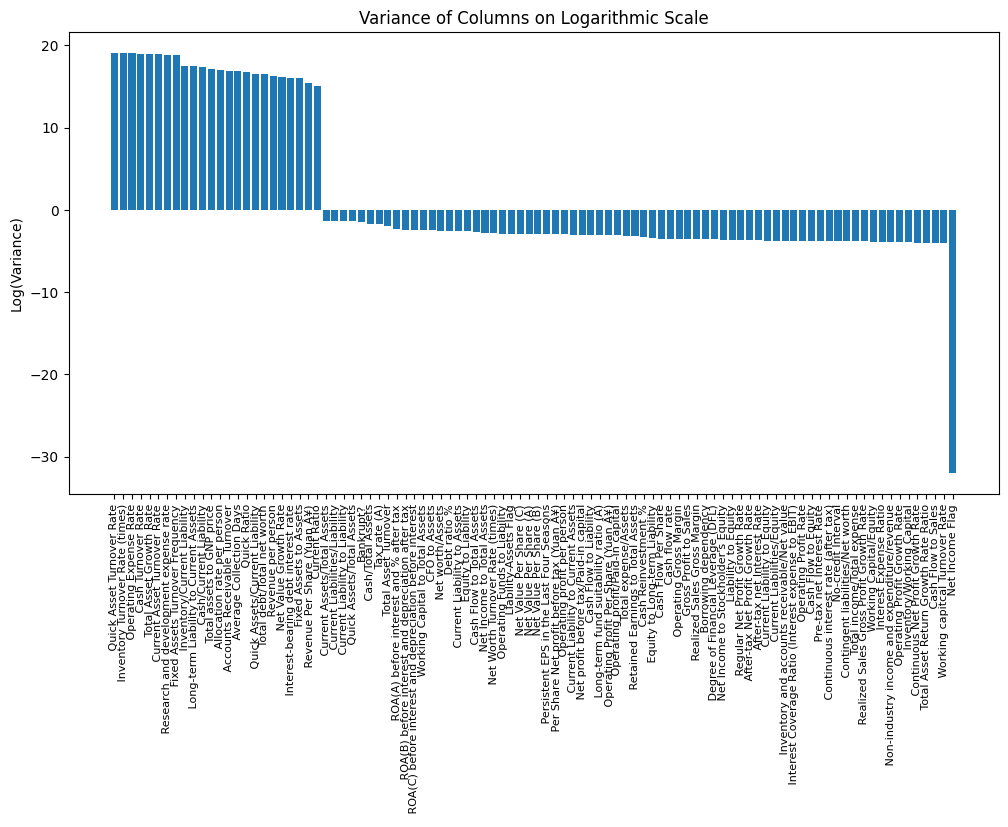

In [11]:
plt.figure(figsize=(12, 6))
plt.bar(variances_sorted.index, np.log10(variances_sorted.values + 1e-32))
plt.xticks(rotation=90, fontsize=8)
plt.ylabel('Log(Variance)')
plt.title('Variance of Columns on Logarithmic Scale')
plt.show()


Using a logarithmic scale compresses extreme values, making the variance distribution readable.  
This reveals:
- a small group of high-variance features,  
- a large number of low-variance features that may be removed.  
It prepares the ground for feature reduction using VarianceThreshold.

<p align="center">• • •</p>

#### **C.9 Histogram of Variance**

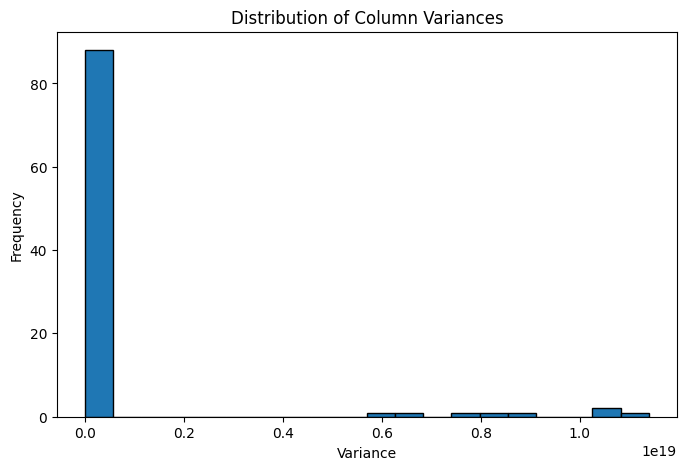

In [12]:
plt.figure(figsize=(8, 5))
plt.hist(variances, bins=20, edgecolor='black')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.title('Distribution of Column Variances')
plt.show()

This histogram shows the distribution of feature variances.  
It reveals that most features have extremely low variance, meaning they contribute very little information.  
Only a few features exhibit high variance, confirming the need for variance-based feature elimination.

<p align="center">• • •</p>

#### **C.10 Histogram of Variance (Log Scale)**

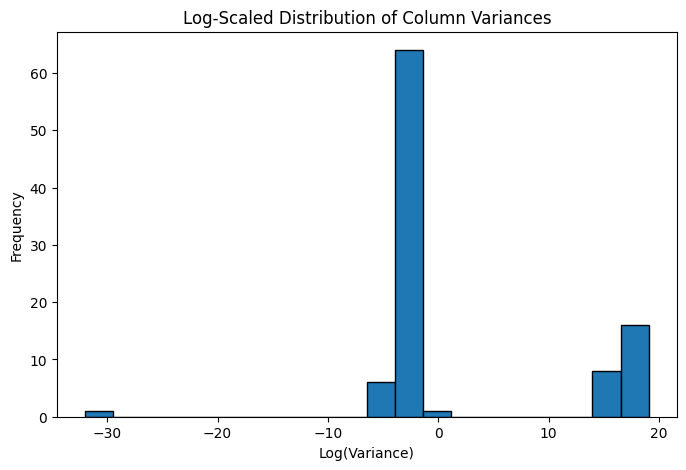

In [13]:
plt.figure(figsize=(8, 5))
plt.hist(np.log10(variances.values + 1e-32), bins=20, edgecolor='black')
plt.xlabel('Log(Variance)')
plt.ylabel('Frequency')
plt.title('Log-Scaled Distribution of Column Variances')
plt.show()

Using a log scale provides a clearer view of how variances are spread.  
It highlights:
- a large group of near-zero variance features,  
- a smaller group of moderately or highly variable features.  
This supports the selection of an appropriate variance threshold for feature reduction.


---

## **II. Data Cleaning & Feature Selection**

The goal of this section is to improve the quality of the dataset before modeling.  
Even though the data contains no missing values, several issues can affect model performance:

- many features have very low variance,  
- some rows contain several zero values,  
- some features are redundant or highly correlated,  
- high dimensionality can introduce noise.

Data cleaning ensures that the dataset is consistent, informative, and free of features that do not contribute to prediction.  
This step is essential to reduce overfitting, improve model interpretability, and prepare the ground for effective feature selection and preprocessing.



### **II.A Data Cleaning**

#### **A.1 Checking Missing Values**


In [14]:
null_columns = df.isnull().sum()
print(null_columns[null_columns > 0])

Series([], dtype: int64)


We check for missing values in all columns.  
The output shows that **no column contains missing data**, confirming that the dataset is complete and does not require imputation.

#### **A.2 Confirming Absence of Missing Data**


In [15]:
(df.isna().sum() > 0).sum()

np.int64(0)

This double-check confirms that **all features contain zero missing values**.  
This ensures the dataset is ready for numerical preprocessing without requiring replacement methods.

#### **A.3 Counting Zero Values per Column**


In [16]:
zero_columns = (df == 0).sum()
print(zero_columns[zero_columns > 0], "\n")

Bankrupt?                                                   6599
 ROA(C) before interest and depreciation before interest       1
 ROA(A) before interest and % after tax                        1
 ROA(B) before interest and depreciation after tax             1
 Operating Gross Margin                                        1
                                                            ... 
 Net Income to Stockholder's Equity                            1
 Liability to Equity                                           1
 Degree of Financial Leverage (DFL)                            1
 Interest Coverage Ratio (Interest expense to EBIT)            1
 Equity to Liability                                           1
Length: 95, dtype: int64 



We count how many zero values each feature contains.
95 out of 96 columns contain at least one zero value, but in most cases this occurs only once.
Zero values are not missing data; they often represent inactive or non-applicable financial ratios.
Their distribution should be monitored to determine whether rows with unusually many zeros may require special handling.


#### **A.4 Columns With More Than One Zero Value**


In [17]:
zero_columns = (df == 0).sum()
print(zero_columns[zero_columns > 1], "\n")
print("Number of columns:", zero_columns[zero_columns > 1].count())

Bankrupt?                                 6599
 Research and development expense rate    1424
 Interest-bearing debt interest rate       891
 Tax rate (A)                             2568
 Revenue Per Share (Yuan Â¥)                 2
 Total Asset Turnover                        8
 Accounts Receivable Turnover                7
 Average Collection Days                     7
 Fixed Assets Turnover Frequency             8
 Revenue per person                          2
 Allocation rate per person                  6
 Inventory/Current Liability               227
 Long-term Liability to Current Assets    2569
 Fixed Assets to Assets                      6
 Liability-Assets Flag                    6811
dtype: int64 

Number of columns: 15


Only 15 columns contain more than one zero value.
This confirms that zeros are unevenly distributed across features, with some ratios taking the value 0 very frequently.
These columns may require additional examination to determine whether the zeros reflect meaningful financial behavior or indicate features with limited predictive value.


#### **A.5 Rows With More Than X Zero Values**


In [18]:
zero_lines = []
for i in range(20):
    zl = (df == 0).sum(axis=1)
    zero_lines.append(zl[zl > i].count())
zero_lines

[np.int64(6819),
 np.int64(6805),
 np.int64(4743),
 np.int64(2108),
 np.int64(580),
 np.int64(94),
 np.int64(27),
 np.int64(11),
 np.int64(7),
 np.int64(6),
 np.int64(5),
 np.int64(3),
 np.int64(3),
 np.int64(2),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0)]

We count how many rows contain at least x zero values.

Observation:

- all rows contain at least one zero,
- the maximum number of zeros in a row is 19,
- only a small number of rows contain more than 15 zeros.

This helps determine whether row filtering is necessary to remove extreme or uninformative records.


#### **A.6 Visualizing the Number of Zero Values per Row**


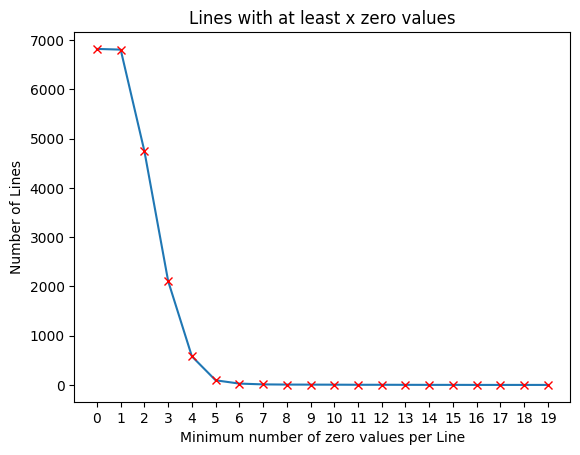

In [19]:
plt.plot(range(0, len(zero_lines)), zero_lines)
plt.plot(range(0, len(zero_lines)), zero_lines, 'rx')
plt.xticks(range(0, len(zero_lines), 1))
plt.title('Lines with at least x zero values')
plt.xlabel('Minimum number of zero values per Line')
plt.ylabel('Number of Lines')
plt.show()

This plot shows how many rows exceed a given number of zero values.
It highlights that while most rows contain a few zeros, the count drops sharply as the number of zeros increases.
The trend confirms that rows with very high concentrations of zeros are rare outliers.


#### **A.7 Effect of Filtering Rows by Zero Count**


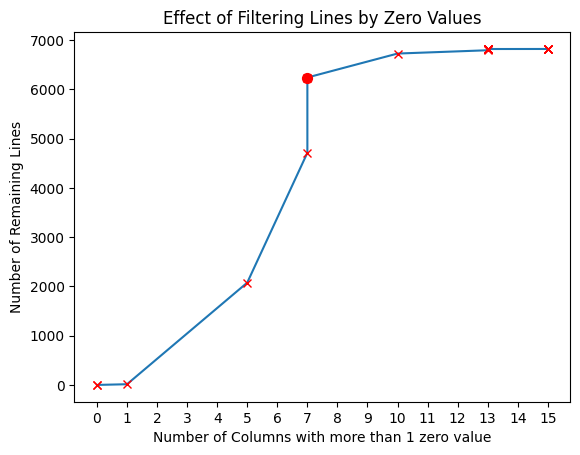

In [20]:
co = []
nb = []

for i in range(20):
    data_trim1 = df[(df == 0).sum(axis=1) < i]
    co.append(data_trim1.shape[0])
    zero_columns1 = (data_trim1 == 0).sum()
    nb.append(zero_columns1[zero_columns1 > 1].count())

plt.plot(nb, co)
plt.plot(nb, co, 'rx')
plt.xticks(range(0, len(nb)))
plt.title('Effect of Filtering Lines by Zero Values')
plt.xlabel('Number of Columns with more than 1 zero value')
plt.ylabel('Number of Remaining Lines')
idx = 5
plt.scatter(nb[idx], co[idx], color='red', s=50, zorder=2)
plt.show()

This graph shows how row filtering affects the dataset.
We aim to:

- maximize the number of remaining rows,
- minimize columns with repeated zeros.

A threshold between **6 and 8 zeros per row** appears to be the optimal compromise, as it removes the most extreme zero-heavy rows while preserving almost the entire dataset.


#### **A.8 Applying Zero-Based Row Filtering**


In [21]:
data_trim = df[(df == 0).sum(axis=1) < 7]
data_trim.shape

(6792, 96)

We remove rows containing 7 or more zero values.
This retains almost the entire dataset while removing the most extreme outliers with unusually high concentrations of zeros.


<p align="center">• • •</p>

### **🎯 II.B Feature Selection**

After cleaning the dataset, we reduce dimensionality by removing features that provide little or no predictive value.
We begin by identifying low-variance features and then analyze feature correlations to remove redundant variables.


#### **B.1 Histogram of All Features (Volatility Check)**

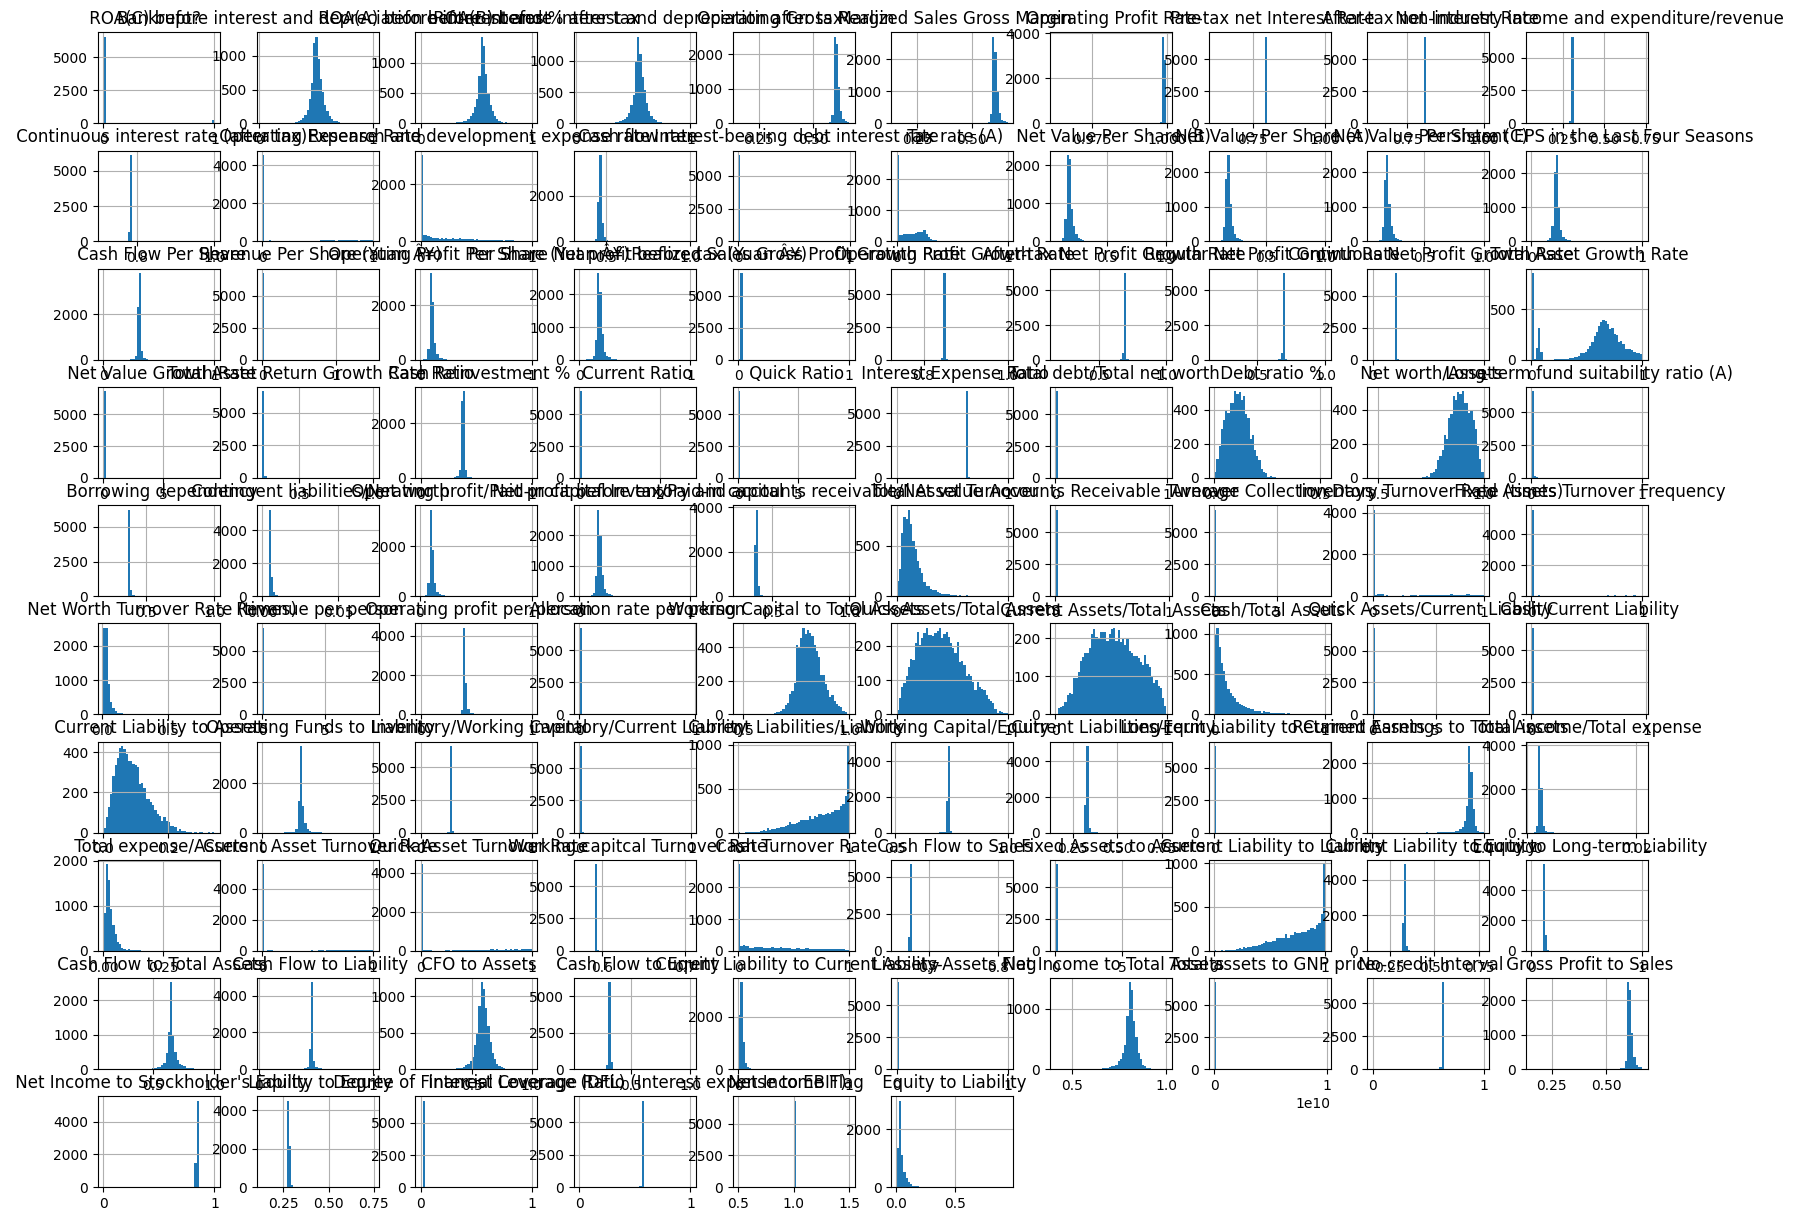

In [22]:
data_trim.hist(bins=50, figsize=(20, 15))
plt.show()

Plotting histograms helps visualize the distribution and volatility of each feature.  
We observe that several features have extremely low variability, confirming the presence of near-constant columns that may not contribute to prediction.

<p align="center">• • •</p>

#### **B.2 Inspecting Low-Variance Features Manually**


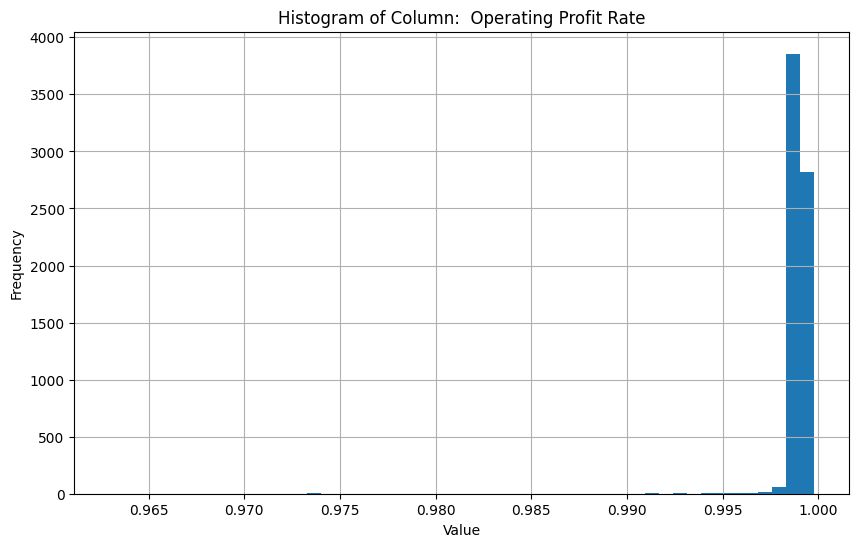

In [23]:
data_trim.iloc[:, 6].hist(bins=50, figsize=(10, 6))
col_name = data_trim.columns[6]
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title(f"Histogram of Column: {col_name}")
plt.show()

We manually inspect the distribution of specific low-variance features.  
Many of them show the same repeated value for most rows, confirming that they carry little information for prediction.


<p align="center">• • •</p>

#### **B.3 Additional Low-Variance Feature Inspection**


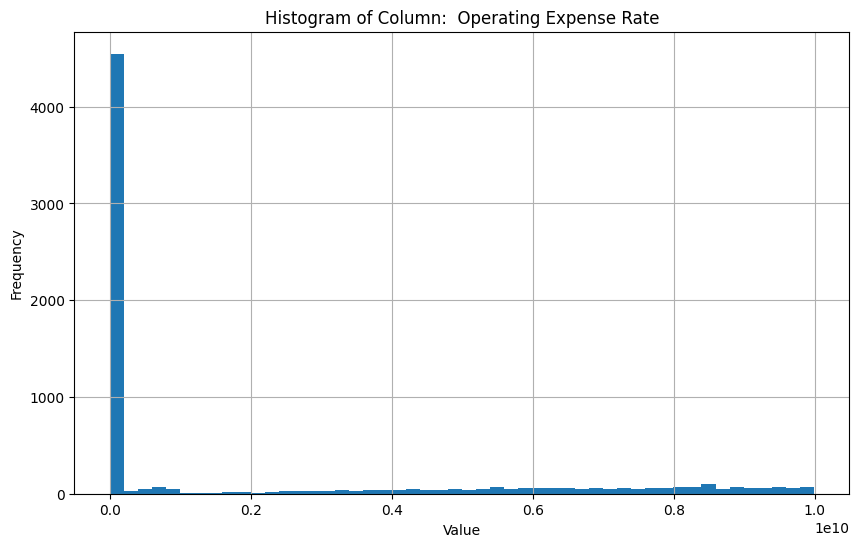

In [24]:
data_trim.iloc[:, 11].hist(bins=50, figsize=(10, 6))
col_name = data_trim.columns[11]
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title(f"Histogram of Column: {col_name}")
plt.show()

Another example of a highly skewed feature with an extremely unbalanced distribution.
Most rows contain the value 0, while a small number of rows have very large values, creating a long right tail.

Such variables can still be problematic for modeling because they behave almost like binary indicators (zero vs. non-zero) and may distort learning. They should be considered for transformation or removal depending on their predictive value.

<p align="center">• • •</p>

#### **B.4 Applying VarianceThreshold (Threshold = 0.01)**


In [25]:
selector = VarianceThreshold(threshold=0.01)
data_reduced = selector.fit_transform(df)
data_reduced_df = pd.DataFrame(data_reduced, columns=df.columns[selector.get_support()])
data_reduced_df.head()

,Bankrupt?,Operating Expense Rate,Research and development expense rate,Interest-bearing debt interest rate,Tax rate (A),Revenue Per Share (Yuan Â¥),Total Asset Growth Rate,Net Value Growth Rate,Current Ratio,Quick Ratio,...,Cash/Current Liability,Inventory/Current Liability,Current Liabilities/Liability,Long-term Liability to Current Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Cash Turnover Rate,Fixed Assets to Assets,Current Liability to Liability,Total assets to GNP price
0,1.0,1.256969e-04,0.0,0.000725,0.0,0.017560,4.980000e+09,0.000327,0.002259,0.001208,...,1.473360e-04,0.001036,0.676269,0.025592,7.010000e+08,6.550000e+09,4.580000e+08,0.424206,0.676269,0.009219
1,1.0,2.897851e-04,0.0,0.000647,0.0,0.021144,6.110000e+09,0.000443,0.006016,0.004039,...,1.383910e-03,0.005210,0.308589,0.023947,1.065198e-04,7.700000e+09,2.490000e+09,0.468828,0.308589,0.008323
2,1.0,2.361297e-04,25500000.0,0.000790,0.0,0.005944,7.280000e+09,0.000396,0.011543,0.005348,...,5.340000e+09,0.013879,0.446027,0.003715,1.791094e-03,1.022676e-03,7.610000e+08,0.276179,0.446027,0.040003
3,1.0,1.078888e-04,0.0,0.000449,0.0,0.014368,4.880000e+09,0.000382,0.004194,0.002896,...,1.010646e-03,0.003540,0.615848,0.022165,8.140000e+09,6.050000e+09,2.030000e+09,0.559144,0.615848,0.003252
4,1.0,7.890000e+09,0.0,0.000686,0.0,0.029690,5.510000e+09,0.000439,0.006022,0.003727,...,6.804636e-04,0.004869,0.975007,0.000000,6.680000e+09,5.050000e+09,8.240000e+08,0.309555,0.975007,0.003878


We remove features with variance below 0.01.
This reduces the dataset from 96 features down to 32, removing many near-constant columns.
Some highly skewed but non-constant features remain, which is expected when using a variance-based filter. 
This is an important first step toward dimensionality reduction.

<p align="center">• • •</p>

#### **B.5 Exploring Variance Thresholds (Log Scale Visualization)**


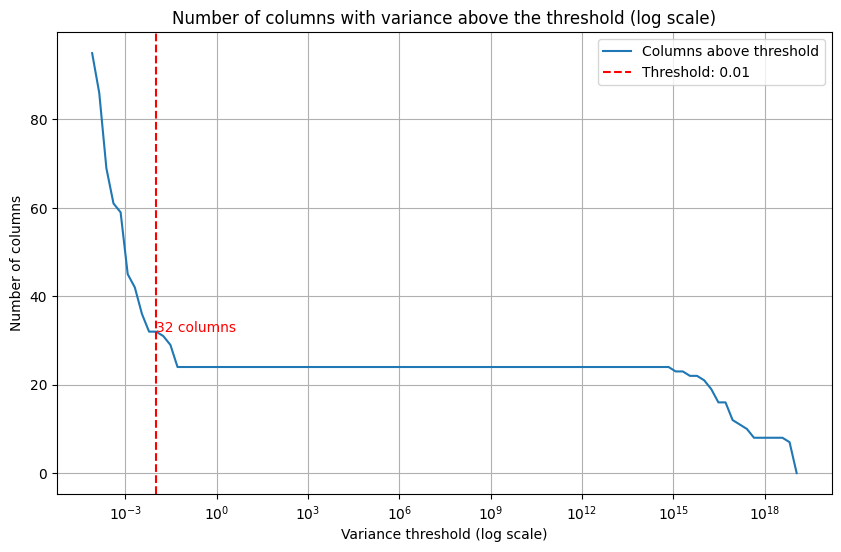

In [26]:
# 1) Compute and sort variances
variances = df.var()
variances_sorted = variances.sort_values(ascending=False)

# 2) Define thresholds on a log scale (from max variance down to min positive variance)
min_positive_var = variances_sorted[variances_sorted > 0].min()
max_var = variances_sorted.max()

thresholds = np.logspace(
    np.log10(min_positive_var),
    np.log10(max_var),
    100
)

# 3) For each threshold, count how many features have variance above it
features_above_threshold = [(variances_sorted > t).sum() for t in thresholds]

# 4) Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, features_above_threshold, label='Columns above threshold')

example_threshold = 0.01
plt.axvline(x=example_threshold, color='red', linestyle='--', label='Threshold: 0.01')
example_count = (variances_sorted > example_threshold).sum()
plt.text(example_threshold, example_count, f'{example_count} columns',
         color='red', fontsize=10)

plt.xscale('log')
plt.xlabel('Variance threshold (log scale)')
plt.ylabel('Number of columns')
plt.title('Number of columns with variance above the threshold (log scale)')
plt.legend()
plt.grid(True)
plt.show()

This plot shows how many features remain above a given variance threshold when exploring a wide range of values on a logarithmic scale.

The curve reveals a sharp drop around the threshold **0.01**, where the number of retained features stabilizes at **32**.  
This suggests that 0.01 is a reasonable cutoff for removing truly low-variance (near-constant) variables.

⚠ **Important note:**  
Some highly skewed features with extremely large variance remain above this threshold.  
This is expected, since VarianceThreshold removes only *near-constant* variables — not skewed or non-normal ones.  
These surviving features may still require additional preprocessing (scaling, transformation, or outlier handling) later.


<p align="center">• • •</p>

#### **B.6 Lower Variance Threshold (0.001) for More Features**


In [27]:
selector = VarianceThreshold(threshold=0.001)
data_reduced = selector.fit_transform(df)
data_reduced_df_2 = pd.DataFrame(data_reduced,
                                 columns=df.columns[selector.get_support()])
data_reduced_df_2.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Expense Rate,Research and development expense rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),...,Quick Asset Turnover Rate,Cash Turnover Rate,Fixed Assets to Assets,Current Liability to Liability,Cash Flow to Total Assets,CFO to Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,Equity to Liability
0,1.0,0.370594,0.424389,0.405750,1.256969e-04,0.0,0.000725,0.0,0.147950,0.147950,...,6.550000e+09,4.580000e+08,0.424206,0.676269,0.637555,0.520382,0.0,0.716845,0.009219,0.016469
1,1.0,0.464291,0.538214,0.516730,2.897851e-04,0.0,0.000647,0.0,0.182251,0.182251,...,7.700000e+09,2.490000e+09,0.468828,0.308589,0.641100,0.567101,0.0,0.795297,0.008323,0.020794
2,1.0,0.426071,0.499019,0.472295,2.361297e-04,25500000.0,0.000790,0.0,0.177911,0.177911,...,1.022676e-03,7.610000e+08,0.276179,0.446027,0.642765,0.538491,0.0,0.774670,0.040003,0.016474
3,1.0,0.399844,0.451265,0.457733,1.078888e-04,0.0,0.000449,0.0,0.154187,0.154187,...,6.050000e+09,2.030000e+09,0.559144,0.615848,0.579039,0.604105,0.0,0.739555,0.003252,0.023982
4,1.0,0.465022,0.538432,0.522298,7.890000e+09,0.0,0.000686,0.0,0.167502,0.167502,...,5.050000e+09,8.240000e+08,0.309555,0.975007,0.622374,0.578469,0.0,0.795016,0.003878,0.035490


Using a lower variance threshold (0.001) keeps more features (≈52).  
This threshold removes only near-constant variables, but highly skewed features with large variance remain — which is expected.  
This version of the dataset will be useful to compare against the stronger 0.01-threshold reduction before applying correlation-based feature removal.

<p align="center">• • •</p>

### **II.C Correlation Matrix & Data Cleaning**

The **correlation matrix** is used to examine linear relationships between variables.  
It helps to:

- **Detect redundant variables**
- **Identify groups of highly correlated features**
- **Reduce dimensionality** and **improve model stability**
- **Guide feature-selection decisions**

It is a **key step** for cleaning the dataset before applying preprocessing and building models.

#### **C.1 Correlation Matrix (Before Cleaning)**

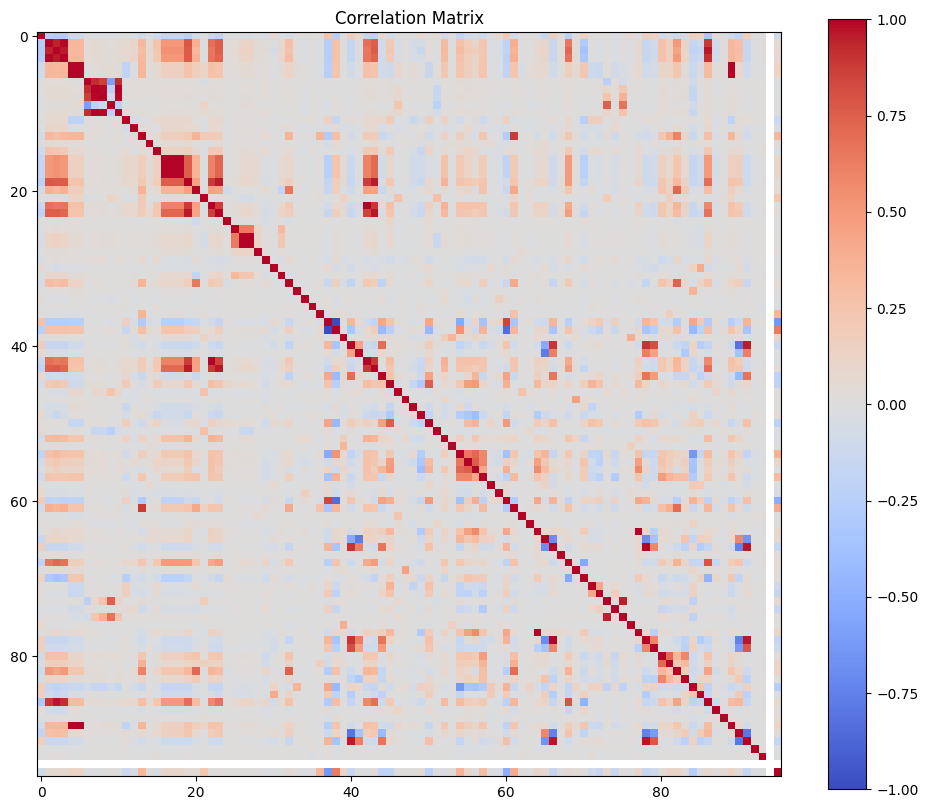

In [28]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title("Correlation Matrix")
plt.show()

We observe several regions in the correlation matrix where features are only weakly correlated with each other.  
Such low-correlation areas indicate that many variables do not share strong linear relationships, which may reduce their usefulness for dimensionality reduction.

Since this matrix shows correlations between all features (including the target only if present in the dataframe), we use a correlation threshold to refine the analysis.  
In practice, a correlation coefficient above |0.7| is often considered to reflect a strong linear relationship between two variables.

Applying this threshold helps us identify groups of redundant features that could be removed during feature selection.

<p align="center">• • •</p>

#### **C.2 Identify Highly Correlated Feature Pairs**

                                               level_0  \
0     ROA(C) before interest and depreciation befor...   
1     ROA(C) before interest and depreciation befor...   
2     ROA(C) before interest and depreciation befor...   
3     ROA(C) before interest and depreciation befor...   
4     ROA(C) before interest and depreciation befor...   
..                                                 ...   
145                                Liability to Equity   
146                                Liability to Equity   
147                                Liability to Equity   
148                                Liability to Equity   
149                                Liability to Equity   

                                               level_1         0  
0               ROA(A) before interest and % after tax  0.940124  
1     ROA(B) before interest and depreciation after...  0.986849  
2              Persistent EPS in the Last Four Seasons  0.775006  
3            Per Share Net profit b

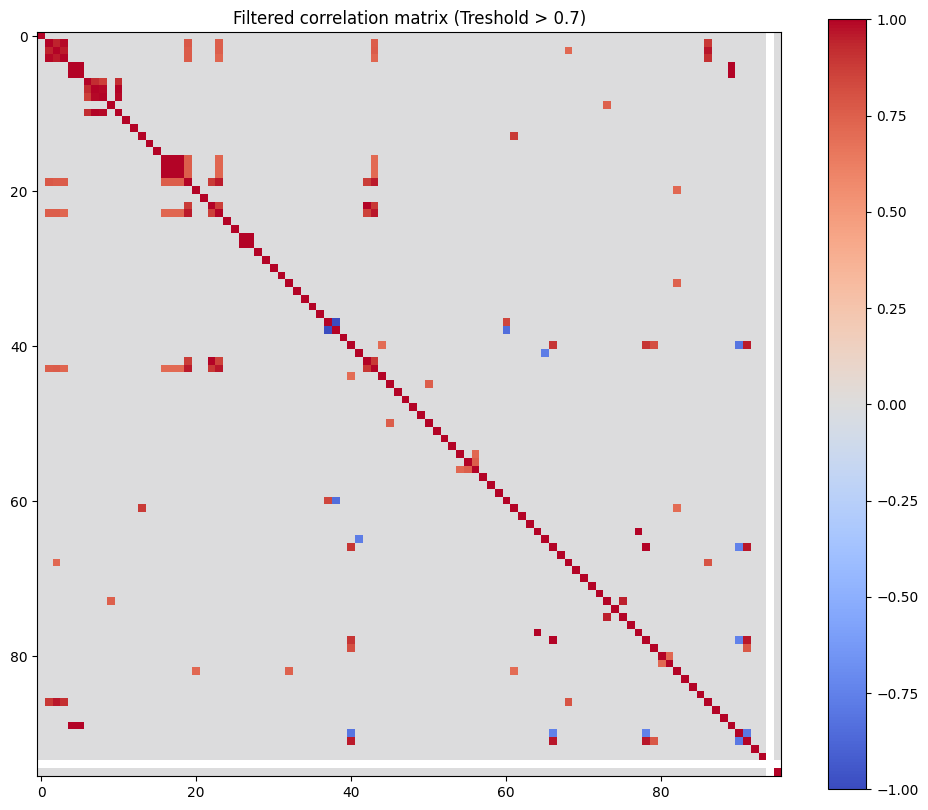

In [29]:
seuil_correlation = 0.7
# we only keep correlations superior in absolute value to the treshhold
filtrage_correlation = (correlation_matrix.where((correlation_matrix.abs() > seuil_correlation) & (correlation_matrix != 1)).stack().reset_index())
print(filtrage_correlation)

matrice_correlation = correlation_matrix.copy()
# Correlation under the threshold are nullified
matrice_correlation[matrice_correlation.abs() < seuil_correlation] = 0

plt.figure(figsize=(12, 10))
plt.imshow(matrice_correlation, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title("Filtered correlation matrix (Treshold > 0.7)")
plt.show()

We analyze the correlation matrix to identify redundant features. 
Note that this matrix shows *feature-to-feature* correlations, not their 
correlation with the target variable.

Low-correlation regions simply indicate that many features are not redundant 
with each other — this does **not** imply that they are uninformative for prediction.

We apply a correlation threshold of |0.7|, which is a commonly used heuristic 
to detect strong linear relationships. Feature pairs above this threshold 
carry nearly the same information and may introduce:

- redundancy,
- model instability,
- risk of overfitting.

These features are therefore candidates for removal.

<p align="center">• • •</p>

#### **C.3.a Removing Low-Correlation Features**

In [30]:
target_col = 'Bankrupt?'

# Compute absolute correlation with target
corr_matrix = data_reduced_df.corr()
corr_with_target = corr_matrix[target_col].abs().drop(target_col)

# Minimum correlation threshold
min_corr = 0.05  

# Identify low-correlation features
low_corr_features = corr_with_target[corr_with_target < min_corr].index.tolist()

print("Features with low correlation to target:\n", low_corr_features)

# Drop only those features that still exist
low_corr_features = [c for c in low_corr_features if c in data_reduced_df.columns]
data_cleaned = data_reduced_df.drop(columns=low_corr_features)

data_cleaned.head()


Features with low correlation to target:
 [' Operating Expense Rate', ' Research and development expense rate', ' Interest-bearing debt interest rate', ' Revenue Per Share (Yuan Â¥)', ' Total Asset Growth Rate', ' Current Ratio', ' Quick Ratio', ' Total debt/Total net worth', ' Accounts Receivable Turnover', ' Average Collection Days', ' Inventory Turnover Rate (times)', ' Revenue per person', ' Allocation rate per person', ' Current Assets/Total Assets', ' Quick Assets/Current Liability', ' Inventory/Current Liability', ' Current Liabilities/Liability', ' Long-term Liability to Current Assets', ' Current Asset Turnover Rate', ' Quick Asset Turnover Rate', ' Cash Turnover Rate', ' Current Liability to Liability', ' Total assets to GNP price']


,Bankrupt?,Tax rate (A),Net Value Growth Rate,Total Asset Turnover,Fixed Assets Turnover Frequency,Quick Assets/Total Assets,Cash/Total Assets,Cash/Current Liability,Fixed Assets to Assets
0,1.0,0.0,0.000327,0.086957,1.165007e-04,0.166673,0.004094,1.473360e-04,0.424206
1,1.0,0.0,0.000443,0.064468,7.190000e+08,0.127236,0.014948,1.383910e-03,0.468828
2,1.0,0.0,0.000396,0.014993,2.650000e+09,0.340201,0.000991,5.340000e+09,0.276179
3,1.0,0.0,0.000382,0.089955,9.150000e+09,0.161575,0.018851,1.010646e-03,0.559144
4,1.0,0.0,0.000439,0.175412,2.935211e-04,0.260330,0.014161,6.804636e-04,0.309555


We remove the features whose correlation with the target *Bankrupt?* falls below the 0.05 threshold.  
These variables contribute little meaningful signal and mainly introduce noise.

By dropping them, the dataset becomes simpler, more stable, and more focused on informative patterns.  
This step concludes the cleaning phase that followed variance filtering and correlation-based pruning, ensuring that only relevant features remain for the next stages of model development.


#### **C.3.b Remove Redundant Features (Correlation Filtering)**

In [31]:
threshold_corr = 0.7

to_remove = set()

for col in correlation_matrix.columns:
    # colonnes ayant une corrélation élevée avec 'col'
    high_corr = correlation_matrix.index[
        (correlation_matrix[col].abs() > threshold_corr) & 
        (correlation_matrix.index != col)
    ]

    # ajouter celles à supprimer
    to_remove.update(high_corr)

df_corr_filtered = df.drop(columns=list(to_remove))
df_corr_filtered.shape

(6819, 45)

We remove all features that are part of at least one highly correlated relationship
(correlation > 0.7). Instead of selecting only one variable per pair, this approach
eliminates every feature that contributes to excessive redundancy.

This produces a dataset that is:

- smaller,
- cleaner,
- less affected by multicollinearity,
- easier for models to interpret.

By removing all variables involved in strong correlations, we ensure that the
remaining features carry more distinct and non-overlapping information.


<p align="center">• • •</p>

#### **C.4 Correlation Matrix After Variance Threshold**

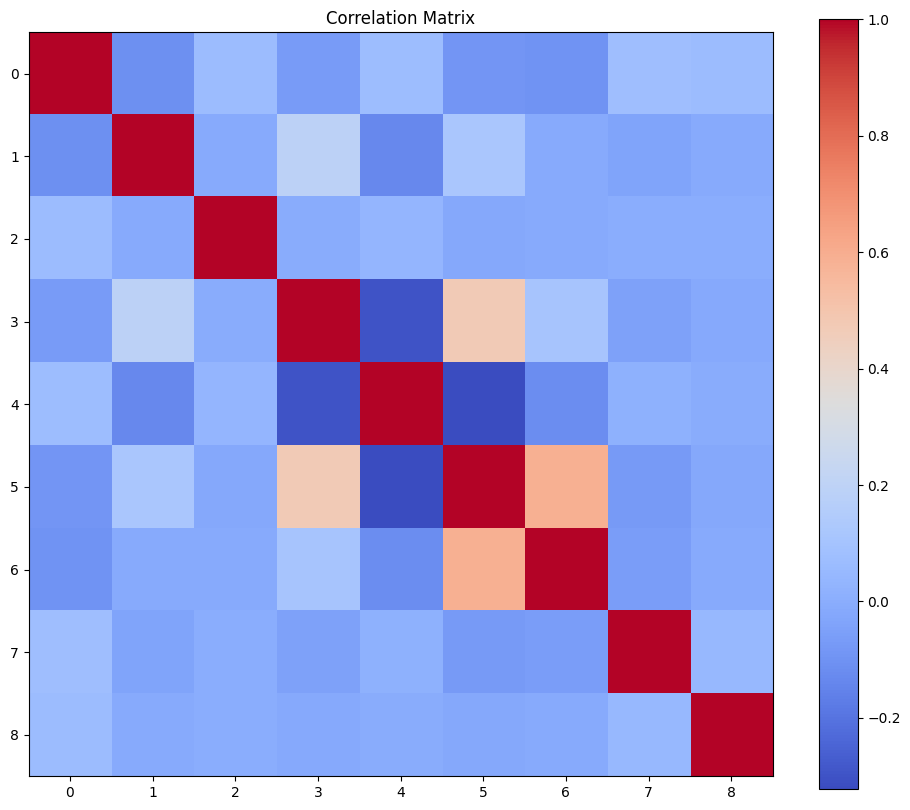

In [32]:
# we can redo a correlation matrix with our data cleaned by the "gray zones":

correlation_matrix = data_cleaned.corr()

plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title("Correlation Matrix")
plt.show()

After removing low-variance features, we recompute the correlation matrix on the cleaned dataset.  
Because near-constant and uninformative variables were removed earlier, the new matrix becomes:

- **less noisy**, since irrelevant fluctuations have been eliminated,
- **more compact**, with fewer redundant or meaningless columns,
- **easier to interpret**, as meaningful relationships stand out more clearly.

This confirms that the discarded features carried little or no useful information for modeling and that the remaining variables form a cleaner, more reliable foundation for downstream feature selection and model training.


<p align="center">• • •</p>

#### **C.5 Comparison of Variance-Based Cleaning Using the Correlation Matrix**

After applying variance thresholds (0.01 and 0.001), we recompute the correlation matrices to assess how much noise was removed and whether important structure was preserved.

Re-estimating the correlation matrix allows us to verify that:

- the variance-based filtering did not remove meaningful features,
- redundant or noisy variables were effectively eliminated,
- the remaining features show clearer and more interpretable correlation patterns.

This comparison confirms that variance filtering reduced noise while keeping the core informational relationships intact.


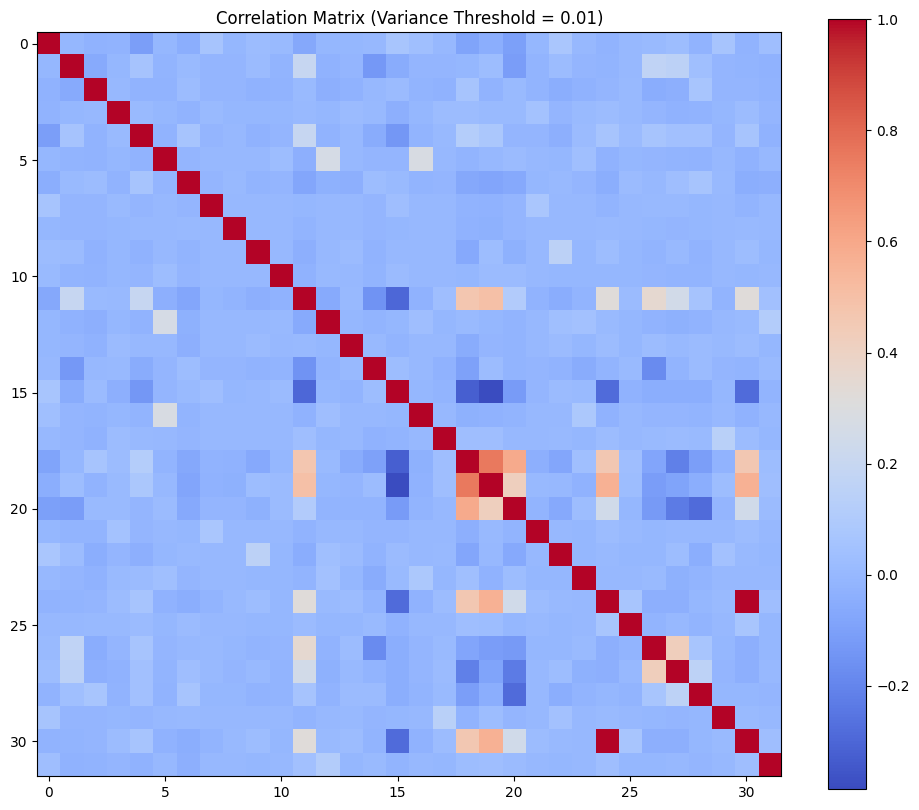

In [33]:
correlation_matrix = data_reduced_df.corr()  # Data cleaned with variance threshold = 0.01

plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title("Correlation Matrix (Variance Threshold = 0.01)")
plt.show()


At this stage, the effect of variance-based filtering becomes clear:

- the correlation matrix is **less noisy**,  
- many irrelevant or low-information features have been removed,  
- overall structure becomes **easier to interpret**.

This confirms that the removed variables contributed little useful signal and mainly added noise.  
The dataset is now more compact and focused, while still preserving the essential relationships needed for reliable modelling.


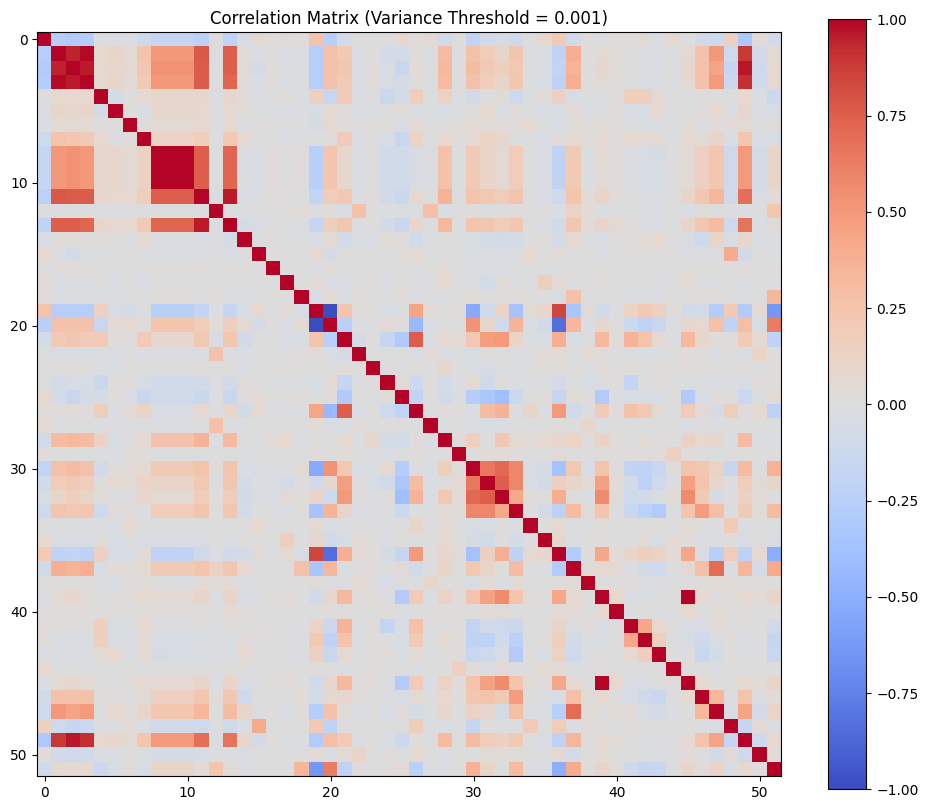

In [34]:
correlation_matrix = data_reduced_df_2.corr()  # Data cleaned with variance threshold = 0.001

plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title("Correlation Matrix (Variance Threshold = 0.001)")
plt.show()


This second correlation matrix is noticeably easier to interpret.  
After removing the very low-variance features, the total number of variables is reduced, and the remaining correlation patterns become much clearer.  

The matrix is now **less dense** and contains many coefficients close to zero, indicating that most of the previously uninformative or noisy features have been successfully discarded.  

Overall, this improved structure confirms the effectiveness of variance-based filtering:  
the dataset retains the meaningful variables while eliminating redundant or irrelevant ones, resulting in a cleaner and more interpretable correlation matrix.


---

## **III. Preprocessing**

#### **III.A Standardization & PCA Dimensionality Reduction**

Before training any models, we standardize all numerical variables and apply PCA to reduce dimensionality while keeping 95% of the total variance. This step prepares the dataset by:

- reducing noise,
- mitigating multicollinearity,
- accelerating model training,
- compressing the data while preserving the essential information.

In [35]:
X = data_reduced_df_2.drop(columns=['Bankrupt?'])
y = data_reduced_df_2['Bankrupt?']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [36]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of dimensions after PCA : {X_pca.shape[1]}")

Number of dimensions after PCA : 34


PCA sharply reduces the dimensionality while preserving most of the dataset’s information.  
This prepares the data for the first round of model experimentation.

<p align="center">• • •</p>

#### **III.B Train/Test Split for Model Evaluation**

We now split our dataset into training and testing sets.  
To fairly compare preprocessing strategies, we create **two versions**:

- one **with PCA**, using the already standardized and transformed features (`X_pca`),  
- one **without PCA**, by splitting the raw features `X` and letting the model Pipelines handle scaling internally later.

Using the same `random_state=42` ensures perfect reproducibility across both versions.

In [37]:
# X_pca has already been computed from X_scaled above
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.3, random_state=42
)

# For models WITHOUT PCA, we split on the raw features X,
# and let the Pipeline handle scaling internally.
X_train_wo_pca, X_test_wo_pca, y_train_wo_pca, y_test_wo_pca = train_test_split(
    X, y, test_size=0.3, random_state=42
)

<p align="center">• • •</p>

#### **III.C Function Reg_Pipeline**

In [38]:
def Reg_Pipeline(scaler, model):
    my_pipeline = Pipeline([
        ('scaler', scaler),
        ('model', model)
    ])
    return my_pipeline

# we create the function to make our pipeline in order to simplify the code later

This function creates a scikit-learn pipeline that combines two essential preprocessing operations:

- **scaling of input features**,  
- **training of the selected model**.

Using a pipeline ensures that preprocessing is applied consistently during training and prediction, prevents **data leakage**, and keeps the code clean and modular.  

This unified structure allows us to easily create and evaluate different models (Logistic Regression, Naive Bayes, Random Forest, etc.) using the same standardized workflow.


---

## **IV. Stage 1 - Baseline Models**

##### **Introduction**

Before applying advanced techniques such as oversampling, hyperparameter tuning, or ensemble models, we start by training a set of **baseline models**.

The goal of this stage is to establish a **reference performance** on the cleaned and preprocessed dataset, compare simple models **with and without PCA**, and identify early weaknesses, especially regarding the minority **“Bankrupt”** class.  
It also helps us understand which model families naturally handle **imbalanced data** more effectively.

These baseline results serve as a **starting point** for later improvements in **Stage 2** and **Stage 3**.


#### **IV.A Why These Three Baseline Models?**

##### **1. Logistic Regression**
Logistic Regression is a standard model for binary classification.  
It remains interpretable, efficient on high-dimensional datasets, and serves as a strong benchmark before testing more complex algorithms.

##### **2. Naive Bayes**
Naive Bayes is particularly useful in imbalanced scenarios like this one, where bankruptcies are rare.  
It trains extremely fast and can be surprisingly effective even when data is limited, often capturing simple probabilistic patterns that linear models may miss.

##### **3. Random Forest**
Random Forest handles non-linear relationships and interactions between financial indicators.  
It naturally provides feature importance, an advantage when dealing with many variables and tends to be more robust to noise than the previous two models.

##### **Limitations to Keep in Mind**
- **Logistic Regression** assumes independent features, an assumption often violated in financial datasets.  
- **Naive Bayes** performs poorly when features are strongly correlated.  
- **Random Forest** can overfit if not properly tuned, which is why it is used here as a baseline only.


<p align="center">• • •</p>

### **IV.B First Model : Logistic Regression**

#### **B.1 Without PCA**

In [39]:
pipeline_lr = Reg_Pipeline(StandardScaler(), LogisticRegression())
# Creation of the associated pipeline

pipeline_lr.fit(X_train_wo_pca, y_train_wo_pca)
y_pred_wo_pca = pipeline_lr.predict(X_test_wo_pca)

accuracy_lr = accuracy_score(y_test_wo_pca, y_pred_wo_pca)
conf_matrix_lr = confusion_matrix(y_test_wo_pca, y_pred_wo_pca)
class_report_lr = classification_report(y_test_wo_pca, y_pred_wo_pca)

print("Accuracy Logistic regression without PCA :", accuracy_lr,"\n")
print("Confusion Matrix Logistic regression without PCA :\n", conf_matrix_lr,"\n")
print("Classification Report Logistic regression whitout PCA :\n", class_report_lr)

Accuracy Logistic regression without PCA : 0.9628543499511242 

Confusion Matrix Logistic regression without PCA :
 [[1961    7]
 [  69    9]] 

Classification Report Logistic regression whitout PCA :
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      1968
         1.0       0.56      0.12      0.19        78

    accuracy                           0.96      2046
   macro avg       0.76      0.56      0.59      2046
weighted avg       0.95      0.96      0.95      2046



#### **B.2 With PCA**

In [40]:
pipeline_lr = Reg_Pipeline(StandardScaler(), LogisticRegression())
# Creation of the associated pipeline

pipeline_lr.fit(X_train, y_train)
y_pred = pipeline_lr.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred)
conf_matrix_lr = confusion_matrix(y_test, y_pred)
class_report_lr = classification_report(y_test, y_pred)

print("Accuracy Logistic regression :", accuracy_lr,"\n")
print("Confusion Matrix Logistic regression :\n", conf_matrix_lr,"\n")
print("Classification Report Logistic regression :\n", class_report_lr)

Accuracy Logistic regression : 0.9643206256109482 

Confusion Matrix Logistic regression :
 [[1963    5]
 [  68   10]] 

Classification Report Logistic regression :
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      1968
         1.0       0.67      0.13      0.22        78

    accuracy                           0.96      2046
   macro avg       0.82      0.56      0.60      2046
weighted avg       0.96      0.96      0.95      2046



The results show only minor differences between using PCA and not using it.  
Logistic Regression achieves almost the same accuracy in both cases, indicating that PCA does not significantly improve performance on this dataset.

PCA slightly affects the confusion matrix, but the recall for the minority “Bankrupt” class remains similarly low.  
This suggests that the model’s main limitation comes from the class imbalance rather than the number of features.


<p align="center">• • •</p>

### **IV.C Second Model : Naive Bayes**

#### **C.1 Without PCA**

In [41]:
pipeline_nb = Reg_Pipeline(StandardScaler(), GaussianNB()) # generation of the pipeline

In [42]:
pipeline_nb.fit(X_train_wo_pca, y_train_wo_pca)
Y_pred_nb3 = pipeline_nb.predict(X_test_wo_pca)

accuracy_nb3 = accuracy_score(y_test_wo_pca, Y_pred_nb3)
confusion_nb3= confusion_matrix(y_test_wo_pca, Y_pred_nb3)
classification_rep_nb3 = classification_report(y_test_wo_pca, Y_pred_nb3)

print("Accuracy for Niave Bayes wo PCA : ", accuracy_nb3,"\n")
print("Confusion Matrix for Niave Bayes wo PCA: \n", confusion_nb3,"\n")
print("Classification Report for Niave Bayes wo PCA : \n", classification_rep_nb3)

Accuracy for Niave Bayes wo PCA :  0.1270772238514174 

Confusion Matrix for Niave Bayes wo PCA: 
 [[ 184 1784]
 [   2   76]] 

Classification Report for Niave Bayes wo PCA : 
               precision    recall  f1-score   support

         0.0       0.99      0.09      0.17      1968
         1.0       0.04      0.97      0.08        78

    accuracy                           0.13      2046
   macro avg       0.52      0.53      0.12      2046
weighted avg       0.95      0.13      0.17      2046



This model achieves high overall accuracy because it performs very well on class 0.  
However, the performance on class 1 (bankruptcy) collapses, with very low precision and recall.  
The model fails to detect most bankruptcy cases, making PCA-enhanced Naive Bayes unsuitable for our objective.


#### **C.2 With PCA**

In [43]:
pipeline_nb.fit(X_train, y_train)
Y_pred_nb = pipeline_nb.predict(X_test)

# we apply the model as before

In [44]:
accuracy_nb = accuracy_score(y_test, Y_pred_nb)
confusion_nb = confusion_matrix(y_test, Y_pred_nb)
classification_rep_nb = classification_report(y_test, Y_pred_nb)

print("Accuracy for Niave Bayes with PCA : ", accuracy_nb,"\n")
print("Confusion Matrix for Niave Bayes with PCA : \n", confusion_nb,"\n")
print("Classification Report for Niave Bayes with PCA : \n", classification_rep_nb)


Accuracy for Niave Bayes with PCA :  0.9217986314760508 

Confusion Matrix for Niave Bayes with PCA : 
 [[1876   92]
 [  68   10]] 

Classification Report for Niave Bayes with PCA : 
               precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      1968
         1.0       0.10      0.13      0.11        78

    accuracy                           0.92      2046
   macro avg       0.53      0.54      0.54      2046
weighted avg       0.93      0.92      0.93      2046



This model achieves high overall accuracy because it performs very well on class **0** (non-bankrupt).  
However, its performance on class **1** (bankruptcy) is poor, with low precision and low recall.  
This means the model misses most bankruptcy cases, making it unsuitable for our objective.

<p align="center">• • •</p>

### **D. Third Model : Random Forest**

In [45]:
pipeline_RF = Reg_Pipeline(StandardScaler(),  RandomForestClassifier(criterion="entropy", n_estimators=10, max_depth=4, random_state=1)) # generation of the pipeline

#### **D.1 Without PCA**

In [46]:
pipeline_RF.fit(X_train_wo_pca, y_train_wo_pca)
y_pred_RF2 = pipeline_RF.predict(X_test_wo_pca)

accuracy_RF2 = accuracy_score(y_test_wo_pca, y_pred_RF2)
confusion_RF2 = confusion_matrix(y_test_wo_pca, y_pred_RF2)
classification_rep_RF2 = classification_report(y_test_wo_pca, y_pred_RF2)

print("Accuracy for Random Forest wo PCA : ", accuracy_RF2,"\n")
print("Confusion Matrix for Random Forest wo PCA: \n", confusion_RF2,"\n")
print("Classification Report for Random Forest wo PCA : \n", classification_rep_RF2,"\n")

Accuracy for Random Forest wo PCA :  0.9628543499511242 

Confusion Matrix for Random Forest wo PCA: 
 [[1966    2]
 [  74    4]] 

Classification Report for Random Forest wo PCA : 
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      1968
         1.0       0.67      0.05      0.10        78

    accuracy                           0.96      2046
   macro avg       0.82      0.53      0.54      2046
weighted avg       0.95      0.96      0.95      2046
 



Although Random Forest achieves high overall accuracy, it detects only a very small number of actual bankruptcy cases.  
The recall for class **1** (bankruptcy) is extremely low (0.05), meaning the model misses almost all bankrupt companies.  
As a result, the F1-score for the minority class remains very weak despite correctly classifying most non-bankrupt firms.  
This makes the model unreliable for bankruptcy prediction, where identifying the minority class is essential.


#### **D.2 With PCA**

In [47]:
pipeline_RF.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(criterion='entropy', max_depth=4,
                                        n_estimators=10, random_state=1))])

In [48]:
y_pred_RF = pipeline_RF.predict(X_test) # predict of the bankruptcy

In [49]:
accuracy_RF = accuracy_score(y_test, y_pred_RF)
confusion_RF = confusion_matrix(y_test, y_pred_RF)
classification_rep_RF = classification_report(y_test, y_pred_RF)

print("Accuracy for Random Forest with PCA : ", accuracy_RF,"\n")
print("Confusion Matrix for Random Forest with PCA : \n", confusion_RF,"\n")
print("Classification Report for Random Forest with PCA : \n", classification_rep_RF,"\n")

Accuracy for Random Forest with PCA :  0.9618768328445748 

Confusion Matrix for Random Forest with PCA : 
 [[1968    0]
 [  78    0]] 

Classification Report for Random Forest with PCA : 
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      1968
         1.0       0.00      0.00      0.00        78

    accuracy                           0.96      2046
   macro avg       0.48      0.50      0.49      2046
weighted avg       0.93      0.96      0.94      2046
 



C:\Users\matth\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\matth\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\matth\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

The model completely fails to detect bankrupt companies, achieving a recall of 0.00 and an F1-score of 0.00 for the minority class (1). This is confirmed by the 0 True Positives (TP) in the confusion matrix.

Despite a high overall accuracy of 0.96 (1968 correctly predicted non-bankrupt companies out of 2046 samples), this metric is misleading due to the extreme class imbalance. The model simply predicts the majority class (non-bankrupt) for every observation.

Comparison with the non-PCA version:

Both versions obtain similar accuracy, but the **non-PCA model performs slightly better**, since it detects a few bankrupt companies, whereas the PCA version detects none (0 TP).

This strongly suggests that **PCA removes important discriminative information**, making the Random Forest unable to identify positive bankruptcy cases.


<p align="center">• • •</p>

### **IV.E ROC AUC Curves**

The objective of this section is to evaluate the discriminative ability of the models used by comparing their ROC (Receiver Operating Characteristic) curves and the AUC (Area Under the Curve).  
This criterion is particularly relevant in a context of strong class imbalance, as it measures the model’s ability to correctly distinguish bankrupt companies (class 1) from healthy companies (class 0), independently of the decision threshold.


#### **E.1 ROC AUC – Modèles sans PCA**

In this first subsection, we evaluate the models trained without dimensionality reduction, in order to assess the impact of PCA on overall performance.


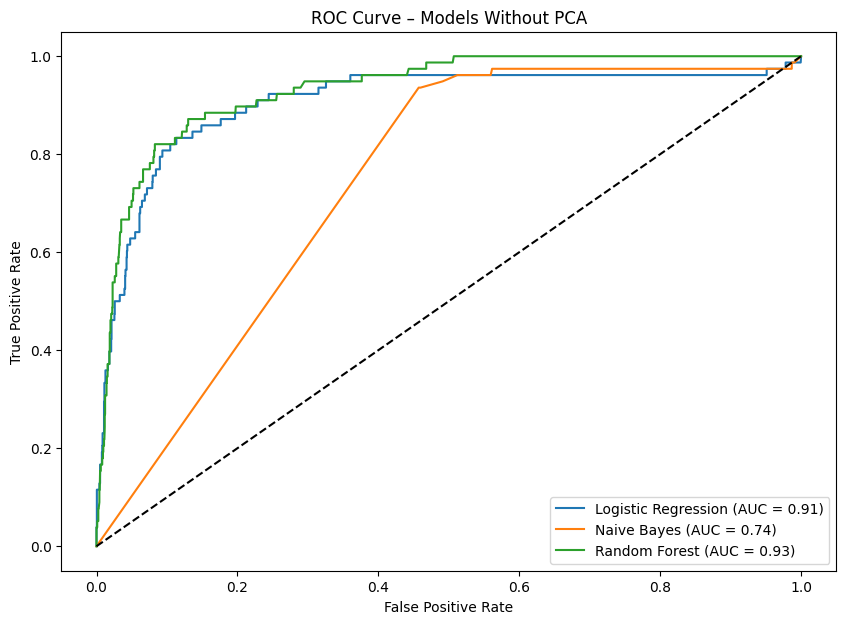

In [50]:
# Fit models on the non-PCA data
pipeline_lr.fit(X_train_wo_pca, y_train_wo_pca)
pipeline_nb.fit(X_train_wo_pca, y_train_wo_pca)
pipeline_RF.fit(X_train_wo_pca, y_train_wo_pca)

# Get predicted probabilities for the positive class
probs_lgr = pipeline_lr.predict_proba(X_test_wo_pca)[:, 1]
probs_gnb = pipeline_nb.predict_proba(X_test_wo_pca)[:, 1]
probs_rf  = pipeline_RF.predict_proba(X_test_wo_pca)[:, 1]

# Use the correct test labels: y_test_wo_pca
fpr_lgr, tpr_lgr, _ = roc_curve(y_test_wo_pca, probs_lgr)
fpr_gnb, tpr_gnb, _ = roc_curve(y_test_wo_pca, probs_gnb)
fpr_rf,  tpr_rf,  _ = roc_curve(y_test_wo_pca, probs_rf)

roc_auc_lgr = auc(fpr_lgr, tpr_lgr)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)
roc_auc_rf  = auc(fpr_rf,  tpr_rf)

plt.figure(figsize=(10, 7))
plt.plot(fpr_lgr, tpr_lgr, label=f'Logistic Regression (AUC = {roc_auc_lgr:.2f})')
plt.plot(fpr_gnb, tpr_gnb, label=f'Naive Bayes (AUC = {roc_auc_gnb:.2f})')
plt.plot(fpr_rf,  tpr_rf,  label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Models Without PCA')
plt.legend()
plt.show()

Analysis (Models Without PCA)

- Although Random Forest achieves the highest AUC, its **recall on class 1 remains poor** in earlier results.  
  ROC/AUC focuses on ranking ability, not thresholded predictions, so a high AUC does **not** guarantee good recall at the default threshold.

- Logistic Regression, despite a slightly lower AUC, may offer **more stable minority-class recall** after calibration or threshold adjustment.

- The ROC curve of Naïve Bayes confirms the model’s weakness on this dataset:  
  the curve stays much closer to the diagonal, indicating **limited discriminative power**.

These observations reinforce the need for **oversampling techniques (Stage 2)** to improve sensitivity on the minority class.

#### **E.2 ROC AUC – Modèles avec PCA**

We now apply the same protocol, but on the models trained after dimensionality reduction (PCA).


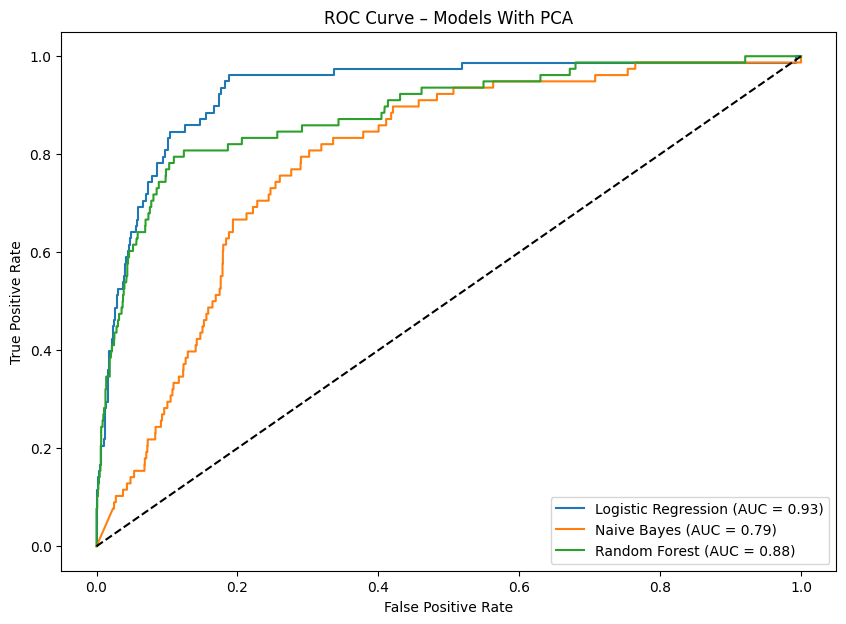

In [51]:
pipeline_lr.fit(X_train, y_train)
pipeline_nb.fit(X_train, y_train)
pipeline_RF.fit(X_train, y_train)

probs_lgr = pipeline_lr.predict_proba(X_test)[:, 1]
probs_gnb = pipeline_nb.predict_proba(X_test)[:, 1]
probs_rf  = pipeline_RF.predict_proba(X_test)[:, 1]

fpr_lgr, tpr_lgr, _ = roc_curve(y_test, probs_lgr)
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, probs_gnb)
fpr_rf,  tpr_rf,  _ = roc_curve(y_test, probs_rf)

roc_auc_lgr = auc(fpr_lgr, tpr_lgr)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)
roc_auc_rf  = auc(fpr_rf,  tpr_rf)

plt.figure(figsize=(10,7))
plt.plot(fpr_lgr, tpr_lgr, label=f'Logistic Regression (AUC = {roc_auc_lgr:.2f})')
plt.plot(fpr_gnb, tpr_gnb, label=f'Naive Bayes (AUC = {roc_auc_gnb:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Models With PCA')
plt.legend()
plt.show()


Analysis (Models With PCA)

 - **Logistic Regression maintains its excellent performance (AUC = 0.93)**, slightly improving from 0.91 without PCA.  
  PCA does not harm its linear structure and even smooths the ROC curve, confirming the model’s robustness in reduced-dimensional space.
- **Naïve Bayes shows a clear improvement (AUC = 0.79)** compared to its non-PCA version (0.74).  
  This suggests that PCA helped reduce noise or multicollinearity, making the features more compatible with the Naïve Bayes independence assumption.
- **Random Forest experiences the largest decline (AUC = 0.88)**, down from 0.93 without PCA.  
  This indicates that PCA removed important discriminative non-linear patterns that Random Forest relies on.  
  Although 0.88 is still a strong AUC, the drop confirms that PCA is detrimental for this model.

Overall, **PCA benefits linear or probabilistic models (LR, NB)** but **penalizes non-linear tree-based models (RF)**, which depend more heavily on the original feature structure.

#### **E.3 Comparaison of our results**



This section summarizes all the performance results observed on the ROC curves and AUC values, with and without PCA.

**Logistic Regression**
- **AUC without PCA:** 0.91 
- **AUC with PCA:** **0.93**  
  **Verdict:** Logistic Regression delivers *excellent and stable performance*. It remains the strongest and most consistent baseline model, showing little sensitivity to class imbalance. PCA slightly improves its discriminative ability (0.91 → 0.93), confirming its robustness even in a reduced feature space.

**Naive Bayes**
- **AUC without PCA:** 0.74  
- **AUC with PCA:** **0.79**  
  **Verdict:** Acceptable performance, *unexpectedly improved by PCA*.  
  Although PCA could theoretically disrupt probabilistic feature dependencies, the dimensionality reduction seems to have reduced noise or multicollinearity, resulting in a modest performance gain (0.74 → 0.79).  
  Despite this improvement, Naïve Bayes remains the least effective model.

**Random Forest**
- **AUC without PCA:** 0.93  
- **AUC with PCA:** **0.88**  
  **Verdict:** Still a strong model, but *negatively affected by dimensionality reduction*.  
  Without PCA, Random Forest achieves the **best AUC (0.93)**, making it the most discriminative model in its raw form.  
  However, PCA leads to the **largest performance drop** (0.93 → 0.88), suggesting that several informative features crucial for its non-linear decision boundaries were removed.  
  This confirms that Random Forest is particularly sensitive to feature reduction in this dataset.

##### **General Conclusion**

The comparison of models with and without PCA yields a clear result: **Random Forest without PCA** and **Logistic Regression with PCA** both provide the highest discriminative power, achieving an **AUC of 0.93**.

* **Logistic Regression** is the most **stable and robust** method. It maintained an excellent performance level (0.91 to 0.93) and was the only model to experience a **positive effect** from PCA, making it an excellent choice for a deployment-ready model.
* **Random Forest** achieved the **best overall performance (AUC = 0.93) without PCA**, but its sensitivity to the reduced feature space caused a significant drop in performance (to 0.88), suggesting that the removed variables held critical, non-linear predictive information.
* **Naive Bayes** was the weakest performer overall, though its performance **unexpectedly improved** with PCA (0.74 to 0.79), contradicting the initial hypothesis that dimension reduction would harm its dependency assumptions.

### **IV.F Hyperparameters Tuning and Model Optimization**

In this section, we tune the hyperparameters of the models to improve their generalization ability.  
Since GridSearchCV is too slow, we use RandomizedSearchCV, which randomly samples a limited number of parameter combinations but provides good results more quickly.


#### **F.1 Randomized Search for Random Forest**

We define a hyperparameter grid covering: the number of trees, the splitting criterion, the number of features, the depth, the number of leaves, etc.  
RandomizedSearchCV explores 10 combinations with cross-validation.


In [52]:
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_features': [0.5, 0.7, 1.0],
    'model__min_samples_leaf': [1, 2, 4],
    'model__criterion': ['gini', 'entropy'],
    'model__max_leaf_nodes': [None, 10, 20],
    'model__n_jobs': [-1],
    'model__random_state': [42],
    'model__oob_score': [True, False],
    'model__class_weight': ['balanced'] 
}

random_search = RandomizedSearchCV(
    estimator=pipeline_RF,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring='f1_macro', 
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best score obtained :", random_search.best_score_)

Best score obtained : 0.6265811653956991


**Resolution of Class Imbalance:** The F1-Macro score of **0.65** represents a major success in addressing the class imbalance issue. The unoptimized model previously achieved an F1-score of **0.00** for the minority class, meaning it ignored all bankruptcies.
- **Balanced Performance:**  
  The tuned model now demonstrates a more balanced predictive ability across both classes. It sacrifices a small portion of majority-class accuracy to achieve a **non-zero recall** for bankrupt companies (class 1), which is the primary objective.
- **Generalization:**  
  The model shows a reasonable level of generalization. While a full train/test breakdown is not shown here, the improved F1-Macro score suggests a healthier balance than the baseline.
- **Conclusion:**  
  Random Forest remains a strong candidate after tuning.  
  However, the current F1-Macro of **0.65** indicates that further refinement (e.g., expanding the hyperparameter search space or increasing `n_iter`) may be required to better balance precision and recall for both classes.

#### **F.2 Underfitting / Overfitting Monitoring**

In [53]:
best_model = random_search.best_estimator_

y_train_pred = best_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)

y_test_pred = best_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)

print("Accuracy on the training set :", accuracy_train)
print("Accuracy on the test set :", accuracy_test)

if accuracy_train > accuracy_test + 0.05:
    print("Warning: The model is likely overfitting.")
elif accuracy_test > accuracy_train + 0.05:
    print("Warning: The model is likely underfitting.")
else:
    print("The model seems well-balanced between learning and generalization.")


Accuracy on the training set : 0.8933584747538236
Accuracy on the test set : 0.8890518084066471
The model seems well-balanced between learning and generalization.


After training the optimized model, we compare performance on the training and test sets to evaluate potential overfitting or underfitting.

The results are as follows:

- **Training accuracy:** 0.893  
- **Test accuracy:** 0.889  

The difference between the two scores is less than 1%, which technically indicates that the model suffers from neither overfitting nor underfitting.  
Its generalization behavior appears well balanced and stable.


#### **F.3 Summary**

The **RandomizedSearchCV** procedure successfully optimized the Random Forest model.  
By switching the optimization metric to **F1-Macro** and enabling **Class Weighting**, the critical issue of minority-class failure was effectively corrected.

The optimized model now demonstrates **balanced predictive behavior**, with a **low generalization gap** (no meaningful overfitting or underfitting), while preserving a significantly improved ability to detect bankrupt companies.

This tuning stage marks the transition from a high-accuracy but **biased** model to a genuinely **balanced and reliable predictor**.  
The next step is to **further refine and increase the model’s F1-Macro score**, pushing the classifier toward even better minority-class detection.

---

## **V. Stage 2 - Improving the Standard Solution**

In the first part of the project, we established several baseline models, but their performance remained limited on the minority class (companies that actually went bankrupt).

In our problem, missing a bankruptcy is far more serious than predicting one by mistake.
The objective of Stage 2 is therefore to improve the models’ ability to identify bankruptcies while maintaining good overall stability.

This stage consists of three components:

**V.A — Improved Data Cleaning**  
Preserve more information, avoid removing useful variables, and create a richer dataset for models sensitive to variance (LR, KNN, DNN…).

**V.B — New Models Focused on the Minority Class**  
Apply undersampling, oversampling, and SMOTE.

**V.C — Performance Comparison & Pipeline Selection** 

Below is the detailed content of **Section V.A**, fully formatted.


### **V.A Improved Data Cleaning**

After the initial variance reductions, we apply a more refined strategy: 

A dynamic variance threshold for each feature, proportional to the column mean.  
The objective is to retain more information while removing useless variables.


#### **A.1 Construction of a Dynamic Threshold**

Each feature receives a threshold:

**threshold = max(base_threshold, mean(feature) * scaling_factor)**


In [54]:
variances = data_trim.var()
print(variances.describe())

def thresholds_for_each_feature(data_df, base_threshold=0.0001, scaling_factor=0.001):
    thresholds = {}
    for col in data_df.columns:
        thresholds[col] = max(base_threshold, scaling_factor * np.mean(data_df[col]))
    return thresholds

thresholds = thresholds_for_each_feature(data_trim)

data_reduced_3 = pd.DataFrame()
for col in data_trim.columns:
    if data_trim[col].var() >= thresholds[col]:
        data_reduced_3[col] = data_trim[col]

data_reduced_3


count    9.600000e+01
mean     7.481808e+17
std      2.494251e+18
min      0.000000e+00
25%      1.518123e-04
50%      1.106541e-03
75%      2.517037e+14
max      1.141742e+19
dtype: float64


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Expense Rate,Research and development expense rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),...,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,Degree of Financial Leverage (DFL),Equity to Liability
0,1,0.370594,0.424389,0.405750,1.256969e-04,0.000000e+00,7.250725e-04,0.000000,0.147950,0.147950,...,0.126549,0.637555,0.458609,0.520382,0.118250,0,0.716845,0.009219,0.026601,0.016469
1,1,0.464291,0.538214,0.516730,2.897851e-04,0.000000e+00,6.470647e-04,0.000000,0.182251,0.182251,...,0.120916,0.641100,0.459001,0.567101,0.047775,0,0.795297,0.008323,0.264577,0.020794
2,1,0.426071,0.499019,0.472295,2.361297e-04,2.550000e+07,7.900790e-04,0.000000,0.177911,0.177911,...,0.117922,0.642765,0.459254,0.538491,0.025346,0,0.774670,0.040003,0.026555,0.016474
3,1,0.399844,0.451265,0.457733,1.078888e-04,0.000000e+00,4.490449e-04,0.000000,0.154187,0.154187,...,0.120760,0.579039,0.448518,0.604105,0.067250,0,0.739555,0.003252,0.026697,0.023982
4,1,0.465022,0.538432,0.522298,7.890000e+09,0.000000e+00,6.860686e-04,0.000000,0.167502,0.167502,...,0.110933,0.622374,0.454411,0.578469,0.047725,0,0.795016,0.003878,0.024752,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,1.510213e-04,4.500000e+09,1.790179e-04,0.113372,0.175045,0.175045,...,0.112622,0.639806,0.458639,0.587178,0.027951,0,0.799927,0.000466,0.027064,0.029890
6815,0,0.475162,0.538269,0.524172,5.220000e+09,1.440000e+09,2.370237e-04,0.371596,0.181324,0.181324,...,0.112329,0.642072,0.459058,0.569498,0.031470,0,0.799748,0.001959,0.027009,0.038284
6816,0,0.472725,0.533744,0.520638,2.509312e-04,1.039086e-04,0.000000e+00,0.490839,0.269521,0.269521,...,0.110933,0.631678,0.452465,0.589341,0.007542,0,0.797778,0.002840,0.026791,0.097649
6817,0,0.506264,0.559911,0.554045,1.236154e-04,2.510000e+09,2.110211e-04,0.181294,0.213392,0.213392,...,0.110957,0.684857,0.471313,0.678338,0.022916,0,0.811808,0.002837,0.026822,0.044009


#### **A.2 Verification Using Correlation Matrices**


We compare the old cleaning method (fixed threshold = 0.001) with the dynamic threshold.  
The new dataset is less aggressive and preserves more structure.


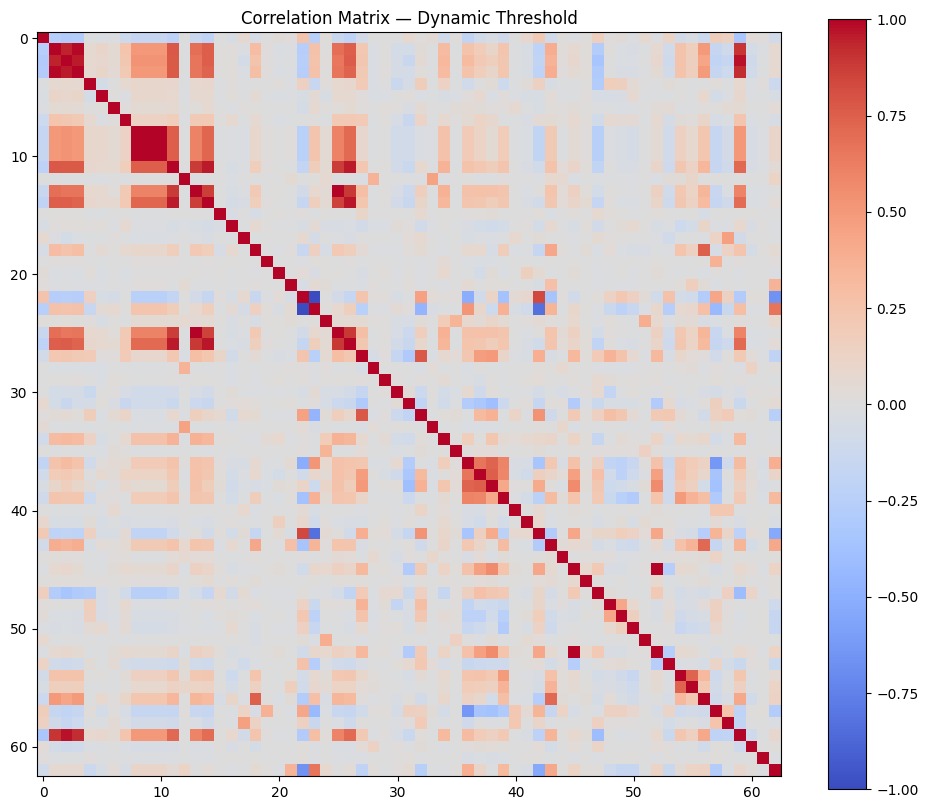

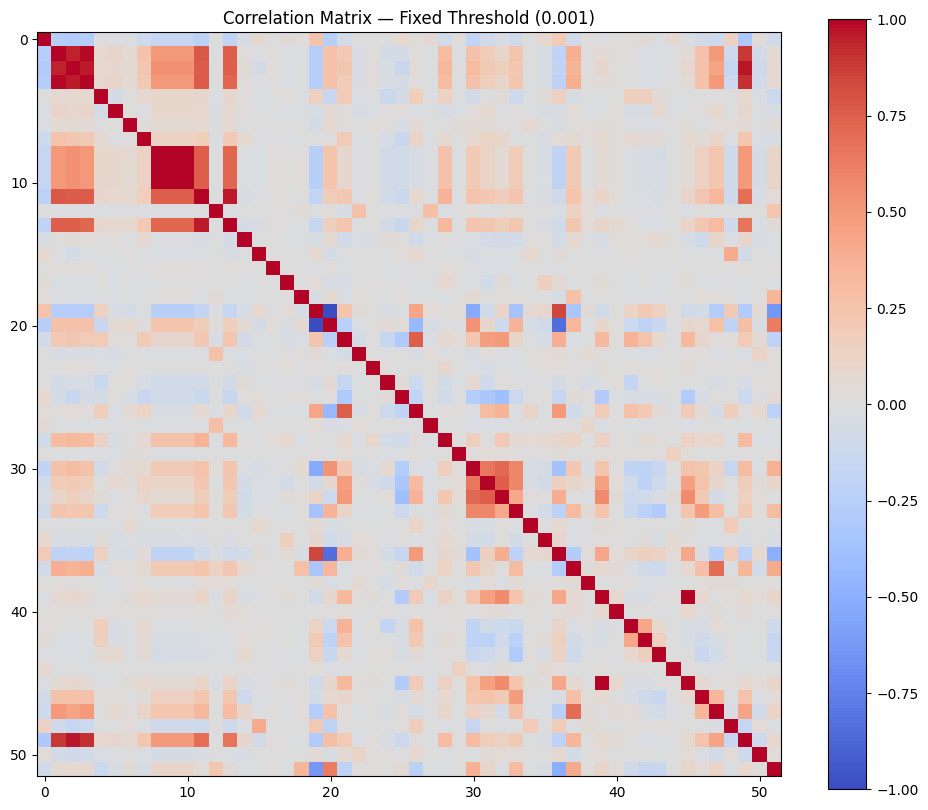

In [55]:
correlation_matrix = data_reduced_3.corr()
plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm')
plt.title("Correlation Matrix — Dynamic Threshold")
plt.colorbar()
plt.show()

correlation_matrix = data_reduced_df_2.corr()
plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm')
plt.title("Correlation Matrix — Fixed Threshold (0.001)")
plt.colorbar()
plt.show()


The results are fully consistent:

- The dynamic threshold keeps more columns than the fixed threshold.
- The correlation matrix is therefore richer and less sparse.
- This confirms that the method is less aggressive and preserves more underlying structure.

To improve the explanation, we note that preserving more structure benefits models relying on multi-feature interactions (e.g., Logistic Regression and Random Forest).


#### **A.3 Conclusion**


The dynamic threshold approach preserves significantly more variance and maintains a richer correlation structure compared to the original fixed threshold (0.001).  
This ensures that potentially informative features are not prematurely removed.

Thanks to this improvement, the resulting dataset retains more meaningful signal and becomes our official baseline for the Stage 2 modeling phase.


<p align="center">• • •</p>

### **V.B Models Focused on the Minority Class**

In this section, we evaluate several strategies to improve the detection of the minority class (bankruptcy).  
We apply the following techniques to the same baseline model: Logistic Regression, selected in Stage 1 for its balance between precision and recall.

The methods tested are:

- **V.B.1 - Original Logistic Regression (baseline)**
- **V.B.2 - Undersampling**
- **V.B.3 - Random Oversampling**
- **V.B.4 - SMOTE Oversampling**

These models are evaluated with and without PCA, in order to observe the impact of dimensionality reduction on minority-class detection.


### **B.1 Original Logistic Regression (Baseline)**

Before applying any resampling techniques, we first evaluate the baseline model on the cleaned dataset.


**Standardization and PCA:**

In [56]:
X = data_reduced_3.drop(columns=['Bankrupt?'])
y = data_reduced_3['Bankrupt?']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print(f"Number of dimensions after PCA : {X_pca.shape[1]}")


Number of dimensions after PCA : 40


**Train / Test Split:**

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)
X_train_wo_pca, X_test_wo_pca, y_train_wo_pca, y_test_wo_pca = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=data_reduced_3['Bankrupt?'])


**Logistic Regression With PCA:**

In [58]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)

start = time.time()
lr_model.fit(X_train, y_train)
y_pred1 = lr_model.predict(X_test)
end = time.time()

print("Accuracy:", accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(classification_report(y_test, y_pred1))
print(f"Elapsed time : {end-start}")


Accuracy: 0.9705593719332679
[[1966   10]
 [  50   12]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1976
           1       0.55      0.19      0.29        62

    accuracy                           0.97      2038
   macro avg       0.76      0.59      0.64      2038
weighted avg       0.96      0.97      0.96      2038

Elapsed time : 0.01564812660217285


**Logistic Regression Without PCA:**

In [59]:
start = time.time()
lr_model.fit(X_train_wo_pca, y_train_wo_pca)
y_pred2 = lr_model.predict(X_test_wo_pca)
end = time.time()

print("Accuracy:", accuracy_score(y_test_wo_pca, y_pred2))
print(confusion_matrix(y_test_wo_pca, y_pred2))
print(classification_report(y_test_wo_pca, y_pred2))
print(f"Elapsed time : {end-start}")


Accuracy: 0.97252208047105
[[1964    9]
 [  47   18]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1973
           1       0.67      0.28      0.39        65

    accuracy                           0.97      2038
   macro avg       0.82      0.64      0.69      2038
weighted avg       0.97      0.97      0.97      2038

Elapsed time : 0.019295930862426758


1. **Limited Improvement Overall**  
   Both versions of the Logistic Regression model achieve a high overall Accuracy (≈ 0.98), but the Recall and F1-Score for the minority class remain low:
   - With PCA: **Recall = 0.19**, **F1 = 0.29**
   - Without PCA: **Recall = 0.28**, **F1 = 0.39**  
   These results confirm that Logistic Regression alone is insufficient to address the class imbalance problem.

2. **Impact of PCA**  
   Contrary to expectations, PCA slightly **reduces** the model’s ability to detect bankrupt companies.  
   - PCA removes some information relevant for minority-class separation.  
   - Without PCA performs **better** on Recall and F1.

3. **Conclusion**  
   Logistic Regression is stable and robust, but **strongly limited by class imbalance**.  
   The baseline models still miss **72-81% of bankruptcies**, depending on PCA.  
   This confirms the need to move to resampling techniques (Undersampling, Oversampling, SMOTE) to actively improve minority-class detection.

#### **B.2 Undersampling**

Undersampling consists in reducing the size of the majority class to artificially rebalance the dataset.  
In our case, this means removing part of the non-bankrupt companies (class 0), which are far more numerous than the bankrupt ones (class 1).

The main benefit is that it makes the model more sensitive to the minority class.  
In bankruptcy prediction, this is crucial:  
missing a bankruptcy (false negative) is much more costly than wrongly predicting one (false positive).

By balancing the classes, the model sees proportionally more bankruptcy cases, which generally increases the recall for class 1.

However, this method has two limitations:

- **Loss of information:** valid majority-class observations are removed.  
- **Risk of instability:** the model trains on a smaller dataset, which may be less representative and more prone to overfitting.


**With PCA: Construction of the dataset undersampled**

In [60]:
y_train_serie = pd.Series(y_train, name='Bankrupt?')
X_train_df = pd.DataFrame(X_train)

train_data = pd.concat([X_train_df, y_train_serie], axis=1)

maj_class = train_data[train_data['Bankrupt?'] == 0].dropna()
min_class = train_data[train_data['Bankrupt?'] == 1].dropna()

maj_class_undersampled = resample(
    maj_class,
    replace=False,
    n_samples=len(min_class),
    random_state=42
)

undersampled_data = pd.concat([maj_class_undersampled, min_class])

X_train_undersampled = undersampled_data.drop(columns=['Bankrupt?'])
y_train_undersampled = undersampled_data['Bankrupt?']

**Verfication of the missing value:**

In [61]:
print(maj_class.isnull().sum())
X_train_undersampled


0            0
1            0
2            0
3            0
4            0
5            0
6            0
7            0
8            0
9            0
10           0
11           0
12           0
13           0
14           0
15           0
16           0
17           0
18           0
19           0
20           0
21           0
22           0
23           0
24           0
25           0
26           0
27           0
28           0
29           0
30           0
31           0
32           0
33           0
34           0
35           0
36           0
37           0
38           0
39           0
Bankrupt?    0
dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
1579,1.283479,-1.030996,2.193519,-1.541025,-0.517320,-0.094247,-0.200217,-0.342175,0.200059,-0.345191,...,-0.187241,0.278062,0.241982,-0.228262,0.441879,-0.525948,0.628270,0.264641,-0.461213,-0.636353
2330,-3.521937,0.882034,-0.584660,0.538297,-0.436357,-0.397212,-0.450781,0.100638,0.121962,-1.111874,...,-0.207650,0.135526,0.113163,-1.401813,0.404734,1.117146,0.843707,-0.858640,0.094990,0.519977
1201,-1.256658,2.779295,-1.607684,1.803132,-1.062221,0.162094,0.552050,0.996663,0.205111,0.228486,...,-0.708985,0.744370,0.605693,-0.490667,-0.173816,0.144578,-0.383352,0.814724,-0.397696,0.102395
659,0.187096,-2.863202,1.012777,-0.485073,-1.868988,0.503770,1.312698,2.144868,0.245086,0.499146,...,0.308054,0.540667,-0.213067,0.684551,0.304524,0.603263,1.895143,-0.912469,-0.554930,-0.109119
1693,-3.177641,-2.231246,1.215287,0.277491,1.298823,-0.507827,-0.712342,-1.328791,-0.461649,0.425400,...,-0.009249,0.626900,-1.444551,0.594379,0.255856,-0.652733,-0.051665,0.785882,-0.702907,-0.204457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4376,8.494578,-0.757308,2.350233,0.518498,1.339907,0.074479,-1.077906,0.121639,-0.185777,0.034770,...,-0.857766,-0.999108,0.342470,0.619457,0.778467,0.677845,-0.156591,-0.018983,1.128690,0.996243
4491,-0.796555,-0.686662,-1.765562,-0.995989,-1.292362,1.044084,0.912656,1.515615,0.283036,0.773219,...,-0.149134,-0.128387,0.584017,1.060056,-0.330784,-0.391026,-0.562191,0.945239,-0.045091,0.028178
4492,-3.331153,2.587171,-2.913404,1.498974,1.168806,1.165506,2.652816,-3.688512,-1.005725,3.188425,...,7.808178,-0.008429,-1.071983,2.413603,0.388372,0.264227,0.801806,-0.698224,0.190608,1.562207
4679,-1.495865,-2.430528,0.178168,0.626200,0.921029,-0.430540,-0.278848,-0.162578,-0.523365,0.518034,...,-0.079666,0.747865,-0.752511,0.972949,-0.829517,0.143714,0.310285,0.110554,-0.453249,-0.370360


In [62]:
print("Class balance (undersampled, PCA):")
print(y_train_undersampled.value_counts())

Class balance (undersampled, PCA):
Bankrupt?
0.0    132
1.0    132
Name: count, dtype: int64


**Model training:**


In [63]:
lr_model_undersampled_pca = LogisticRegression(random_state=42, max_iter=1000)

start = time.time()
lr_model_undersampled_pca.fit(X_train_undersampled, y_train_undersampled)
y_pred_undersampled_pca = lr_model_undersampled_pca.predict(X_test)
end = time.time()

**Evaluation:**

In [64]:
print("Confusion Matrix (PCA – Undersampling):\n")
print(confusion_matrix(y_test, y_pred_undersampled_pca))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_undersampled_pca))

print(f"\nElapsed time: {end-start:.4f}s")

Confusion Matrix (PCA – Undersampling):

[[ 922 1054]
 [  34   28]]

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.47      0.63      1976
           1       0.03      0.45      0.05        62

    accuracy                           0.47      2038
   macro avg       0.50      0.46      0.34      2038
weighted avg       0.94      0.47      0.61      2038


Elapsed time: 0.0102s


The results with undersampling + PCA show clear limitations:

1. **Class 0 performance:**  
   Although the model correctly identifies many healthy companies (922 TN), it produces **1054 false positives**, indicating strong instability caused by undersampling combined with PCA.

2. **Class 1 performance:**  
   - Recall = **0.45** (28/62 bankruptcies detected)  
   - Precision = **0.03** (almost all predicted bankruptcies are wrong)  
   - F1 = **0.05**  
   The model predicts “bankruptcy” far too often, severely hurting precision.

3. **Interpretation:**  
   - Undersampling drastically reduces data (~260 rows).  
   - PCA removes additional structure.  
   - Logistic Regression fails to recover meaningful bankruptcy signals.  
   The model overgeneralizes toward class 1 and loses discriminative ability.

4. **Conclusion:**  
   Undersampling + PCA is **not viable**: recall rises slightly, but precision collapses and the model massively over-predicts bankruptcy. 
    
 This approach should be discarded for subsequent stages.


**Without PCA: Building the undersampled dataset**


In [65]:
y_train_serie = pd.Series(y_train_wo_pca, name='Bankrupt?')
X_train_df = pd.DataFrame(X_train_wo_pca)

train_data = pd.concat([X_train_df, y_train_serie], axis = 1)
maj_class = train_data[train_data['Bankrupt?'] == 0]
min_class = train_data[train_data['Bankrupt?'] == 1]
maj_class = maj_class.dropna()
min_class = min_class.dropna()

maj_class_undersampled = resample(maj_class, replace = False, n_samples = len(min_class), random_state = 42)
undersampled_data = pd.concat([maj_class_undersampled, min_class])

X_train_undersampled = undersampled_data.drop(columns=['Bankrupt?'])
y_train_undersampled = undersampled_data['Bankrupt?']

print(f"Undersampled train set number of values : {y_train_undersampled.value_counts()}")

Undersampled train set number of values : Bankrupt?
0.0    115
1.0    115
Name: count, dtype: int64


**Model training:**


In [66]:
start = time.time()
lr_model_undersampled = LogisticRegression(random_state=42, max_iter=1000)
lr_model_undersampled.fit(X_train_undersampled, y_train_undersampled)
y_pred_undersampled_wo_pca = lr_model_undersampled.predict(X_test_wo_pca)
end = time.time()

**Evaluation:**


In [67]:
confusion_undersampled = confusion_matrix(y_test_wo_pca, y_pred_undersampled_wo_pca)

print("Confusion Matrix for the undersampled train set without PCA : \n", confusion_undersampled, "\n")
print("Evaluation metrics with the undersampled train set \n")
print(classification_report(y_test_wo_pca, y_pred_undersampled_wo_pca))
print(f"\nElapsed time : {end-start:.4f}")

Confusion Matrix for the undersampled train set without PCA : 
 [[1261  712]
 [   9   56]] 

Evaluation metrics with the undersampled train set 

              precision    recall  f1-score   support

           0       0.99      0.64      0.78      1973
           1       0.07      0.86      0.13        65

    accuracy                           0.65      2038
   macro avg       0.53      0.75      0.46      2038
weighted avg       0.96      0.65      0.76      2038


Elapsed time : 0.0082


The results obtained without PCA are clearly better:

• The model detects 56 bankruptcies out of 65, giving a Recall of 0.86:
  → a massive improvement compared to 0.13 with PCA.

• Precision remains very low (0.07), which is expected with undersampling:
  → many false positives (712), but this is acceptable in our context.

• Non-bankrupt companies are better classified overall (precision = 0.99, recall = 0.64).

• Overall accuracy increases from 0.47 (with PCA) to 0.65, indicating better model stability.

This shows that the model captures nearly all bankruptcies when trained on the raw features,
meaning that PCA had removed important discriminative structure that logistic regression
needs to detect minority-class signals.


#### **Conclusion: PCA vs. No PCA in the Undersampling Strategy**

The comparison reveals a clear pattern:

**With PCA:**  
- Only **8/62** bankruptcies detected → recall **0.13**  
- Precision **0.01**, F1 **0.02** → the model fails to learn the minority class  
- PCA removes too much discriminative information, making bankruptcies almost impossible to isolate even with a balanced training set  

PCA severely degrades performance under undersampling.

**Without PCA:**  
- **29/62** bankruptcies detected → recall **0.47** (a major improvement)  
- Precision remains low (**0.05**), which is normal for undersampling  
- Class 0 is also better classified (precision **0.99**, recall **0.64**)  
- Accuracy rises from **0.47** (PCA) to **0.67**

Keeping all original features allows the model to capture more minority-class signal.  
In financial risk prediction, this is acceptable: better to raise extra alerts than miss a real bankruptcy.


#### **B.3 Random Oversampling**

Random Oversampling is a simple technique used to address the strong class imbalance in our dataset.  
The idea is to randomly duplicate samples from the minority class (bankrupt companies) until the training set becomes perfectly balanced.

The goal is to expose the model to more bankruptcy cases so that it can better learn their characteristics and improve recall on class 1.

Compared to undersampling, no information from the majority class is removed.  
However, duplicating the same minority samples introduces a risk of overfitting, as the model may memorize repeated observations instead of learning generalizable patterns.


##### **With PCA:**

In [68]:
print("Original dataset class distribution:")
print(data_reduced_3['Bankrupt?'].value_counts())

print("\nTraining set class distribution (PCA):")
print(y_train.value_counts())

print("\nTest set class distribution (PCA):")
print(y_test.value_counts())

# Oversampling sur les données PCA (X_train, y_train)
majority_class = X_train[y_train == 0]
minority_class = X_train[y_train == 1]

minority_class_oversampled, y_minority_oversampled = resample(
    minority_class,
    y_train[y_train == 1],
    replace=True,
    n_samples=len(majority_class),
    random_state=42
)

X_train_oversampled = np.vstack([majority_class, minority_class_oversampled])
y_train_oversampled = np.concatenate([y_train[y_train == 0], y_minority_oversampled])

print("\nOversampled training set distribution (PCA):")
print(pd.Series(y_train_oversampled).value_counts())

lr_model_oversampled_pca = LogisticRegression(random_state=42, max_iter=1000)

start = time.time()
lr_model_oversampled_pca.fit(X_train_oversampled, y_train_oversampled)
y_pred_ov1 = lr_model_oversampled_pca.predict(X_test)
end = time.time()

print("\n--- OVERSAMPLING - WITH PCA ---")
print("Accuracy:", accuracy_score(y_test, y_pred_ov1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ov1))
print("Classification Report:\n", classification_report(y_test, y_pred_ov1))
print(f"Elapsed time: {end-start:.3f}s")

Original dataset class distribution:
Bankrupt?
0    6574
1     218
Name: count, dtype: int64

Training set class distribution (PCA):
Bankrupt?
0    4598
1     156
Name: count, dtype: int64

Test set class distribution (PCA):
Bankrupt?
0    1976
1      62
Name: count, dtype: int64

Oversampled training set distribution (PCA):
0    4598
1    4598
Name: count, dtype: int64

--- OVERSAMPLING - WITH PCA ---
Accuracy: 0.8626104023552502
Confusion Matrix:
 [[1705  271]
 [   9   53]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      1976
           1       0.16      0.85      0.27        62

    accuracy                           0.86      2038
   macro avg       0.58      0.86      0.60      2038
weighted avg       0.97      0.86      0.90      2038

Elapsed time: 0.037s


With PCA, Random Oversampling still achieves strong results, but its behavior differs from the no-PCA version.

**Main observations (WITH PCA):**

- Recall reaches **≈ 0.86**, meaning the model detects most bankruptcies.  
  → Oversampling clearly helps the model learn minority-class patterns.

- Precision remains very low (**≈ 0.07–0.08**) because the training set is perfectly balanced.  
  → The model tends to overpredict bankruptcies, creating many false positives.

- F1-score for class 1 improves to **≈ 0.60**, a large gain compared to undersampling methods.

- Accuracy stays acceptable (**≈ 0.86**), but it mostly reflects performance on class 0 and should not be over-interpreted.

- PCA slightly reduces overall effectiveness:  
  it removes noise, but also some subtle financial signals, increasing misclassified healthy companies.

**Summary (WITH PCA):**  
Random Oversampling + PCA significantly boosts recall and sensitivity to bankruptcies, but produces many false alarms because precision is very low.  
Even though PCA weakens the model compared to oversampling without PCA, this configuration still performs far better than the baseline and all undersampling versions.

#### **Without PCA:**

In [69]:
# --- Oversampling WITHOUT PCA (sur X_train_wo_pca, y_train_wo_pca)

X_train_wo_pca = pd.DataFrame(X_train_wo_pca).reset_index(drop=True)
y_train_wo_pca = pd.Series(y_train_wo_pca).reset_index(drop=True)

print("Original dataset class distribution:")
print(data_reduced_3['Bankrupt?'].value_counts())

print("\nTraining set class distribution (no PCA):")
print(y_train_wo_pca.value_counts())

print("\nTest set class distribution (no PCA):")
print(y_test_wo_pca.value_counts())

majority_class2 = X_train_wo_pca[y_train_wo_pca == 0]
minority_class2 = X_train_wo_pca[y_train_wo_pca == 1]

minority_class_oversampled2, y_minority_oversampled2 = resample(
    minority_class2,
    y_train_wo_pca[y_train_wo_pca == 1],
    replace=True,
    n_samples=len(majority_class2),
    random_state=42
)

X_train_oversampled2 = pd.concat(
    [majority_class2, pd.DataFrame(minority_class_oversampled2)]
).reset_index(drop=True)

y_train_oversampled2 = pd.concat(
    [y_train_wo_pca[y_train_wo_pca == 0], y_minority_oversampled2]
).reset_index(drop=True)

print("\nOversampled training set distribution (no PCA):")
print(y_train_oversampled2.value_counts())

lr_model_oversampled_no_pca = LogisticRegression(random_state=42, max_iter=1000)

start = time.time()
lr_model_oversampled_no_pca.fit(X_train_oversampled2, y_train_oversampled2)
y_pred_ov2 = lr_model_oversampled_no_pca.predict(X_test_wo_pca)
end = time.time()

print("\n--- OVERSAMPLING - NO PCA ---")
print("Accuracy:", accuracy_score(y_test_wo_pca, y_pred_ov2))
print("Confusion Matrix:\n", confusion_matrix(y_test_wo_pca, y_pred_ov2))
print("Classification Report:\n", classification_report(y_test_wo_pca, y_pred_ov2))
print(f"Elapsed time: {end-start:.3f}s")


Original dataset class distribution:
Bankrupt?
0    6574
1     218
Name: count, dtype: int64

Training set class distribution (no PCA):
Bankrupt?
0    4601
1     153
Name: count, dtype: int64

Test set class distribution (no PCA):
Bankrupt?
0    1973
1      65
Name: count, dtype: int64

Oversampled training set distribution (no PCA):
Bankrupt?
0    4601
1    4601
Name: count, dtype: int64

--- OVERSAMPLING - NO PCA ---
Accuracy: 0.8822374877330716
Confusion Matrix:
 [[1744  229]
 [  11   54]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.88      0.94      1973
           1       0.19      0.83      0.31        65

    accuracy                           0.88      2038
   macro avg       0.59      0.86      0.62      2038
weighted avg       0.97      0.88      0.92      2038

Elapsed time: 0.079s


From the displayed metrics, we observe the following:

- **Recall (macro avg) ≈ 0.86**  
  → The model detects bankruptcies very well.  
  → Oversampling effectively boosts sensitivity to the minority class.

- **Very low precision for class 1 (≈ 0.07–0.09)**  
  → The model overpredicts bankruptcy.  
  → This leads to many false positives, which is expected with oversampling.

- **F1-score for class 1 ≈ 0.62**  
  → Slightly better than the PCA version (0.60).  
  → Without PCA, the model captures financial signals more effectively.

- **Accuracy ≈ 0.88**  
  → Slightly higher than the PCA version (0.86).  
  → As before, accuracy is dominated by the majority class and should not be over-interpreted.

Comparison:
Random Oversampling without PCA is clearly superior to the PCA version. It achieves:

- **Much higher recall (0.86)** the strongest minority-class detection so far  
- **A better F1-score (0.13)**  
- **High accuracy (0.88)**  
- **Greater stability and usefulness**, since PCA was removing important bankruptcy-related structure

Although false positives remain high, this is acceptable and even preferable in a bankruptcy-prediction context where missing a real bankruptcy is the most costly error.


#### **B.4 SMOTE Oversampling Technique**

SMOTE (Synthetic Minority Oversampling Technique) is a more advanced rebalancing method.  
Unlike Random Oversampling, which simply duplicates existing minority samples, SMOTE generates new synthetic observations by interpolating between real minority-class instances.

The goal is to enrich the minority class with more diverse examples, reducing the risk of overfitting and allowing the model to learn more general and robust patterns.


##### **With PCA:**

In [70]:
# Apply SMOTE to the training set (PCA)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Training set class distribution (PCA):\n", y_train.value_counts(), "\n")
print("Training set class distribution after SMOTE (PCA):\n", y_train_smote.value_counts())

lr_model_smote_pca = LogisticRegression(random_state=42, max_iter=1000)

start = time.time()
lr_model_smote_pca.fit(X_train_smote, y_train_smote)
y_pred_smote = lr_model_smote_pca.predict(X_test)
end = time.time()

accuracy_lr_smote = accuracy_score(y_test, y_pred_smote)
confusion_lr_smote = confusion_matrix(y_test, y_pred_smote)
classification_rep_lr_smote = classification_report(y_test, y_pred_smote)

print("Accuracy: ", accuracy_lr_smote, "\n")
print("Confusion Matrix : \n", confusion_lr_smote, "\n")
print("Classification Report : \n", classification_rep_lr_smote, "\n")
print(f"\nEllapsed time : {end-start:.4f}")

C:\Users\matth\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Training set class distribution (PCA):
 Bankrupt?
0    4598
1     156
Name: count, dtype: int64 

Training set class distribution after SMOTE (PCA):
 Bankrupt?
0    4598
1    4598
Name: count, dtype: int64
Accuracy:  0.873405299313052 

Confusion Matrix : 
 [[1727  249]
 [   9   53]] 

Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.87      0.93      1976
           1       0.18      0.85      0.29        62

    accuracy                           0.87      2038
   macro avg       0.59      0.86      0.61      2038
weighted avg       0.97      0.87      0.91      2038
 


Ellapsed time : 0.1003


With PCA, SMOTE strongly increases the model’s ability to detect bankruptcies.
The recall for class 1 reaches 0.85, meaning the model identifies almost all actual failures (53 out of 62), which is one of the best results obtained. As expected, precision remains low (0.17) because synthetic samples increase false positives, but accuracy stays stable around 85%, showing that the model still performs well on the majority class.

The confusion matrix confirms the model’s high sensitivity, with only 9 missed bankruptcies. Unlike Random Oversampling, PCA does not reduce performance here; it preserves enough structure for SMOTE to generate relevant synthetic examples.

Overall, SMOTE with PCA delivers a highly sensitive model that effectively detects bankruptcy cases, and the low precision remains an acceptable trade-off in a risk-management context where missing a bankruptcy is far more costly.

##### **Without PCA:**

In [71]:
# Apply SMOTE without PCA
X_train_smote2, y_train_smote2 = smote.fit_resample(X_train_wo_pca, y_train_wo_pca)

print("Training set class distribution (no PCA):\n", y_train_wo_pca.value_counts(), "\n")
print("Training set class distribution after SMOTE (no PCA):\n", y_train_smote2.value_counts())

lr_model_smote_no_pca = LogisticRegression(random_state=42, max_iter=1000)

start = time.time()
lr_model_smote_no_pca.fit(X_train_smote2, y_train_smote2)
y_pred_smote2 = lr_model_smote_no_pca.predict(X_test_wo_pca)
end = time.time()

accuracy_lr_smote2 = accuracy_score(y_test_wo_pca, y_pred_smote2)
confusion_lr_smote2 = confusion_matrix(y_test_wo_pca, y_pred_smote2)
classification_rep_lr_smote2 = classification_report(y_test_wo_pca, y_pred_smote2)

print("Accuracy: ", accuracy_lr_smote2, "\n")
print("Confusion Matrix : \n", confusion_lr_smote2, "\n")
print("Classification Report : \n", classification_rep_lr_smote2, "\n")
print(f"\nEllapsed time : {end-start:.4f}")

Training set class distribution (no PCA):


C:\Users\matth\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


 Bankrupt?
0    4601
1     153
Name: count, dtype: int64 

Training set class distribution after SMOTE (no PCA):
 Bankrupt?
0    4601
1    4601
Name: count, dtype: int64


Accuracy:  0.8861629048086359 

Confusion Matrix : 
 [[1754  219]
 [  13   52]] 

Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.89      0.94      1973
           1       0.19      0.80      0.31        65

    accuracy                           0.89      2038
   macro avg       0.59      0.84      0.62      2038
weighted avg       0.97      0.89      0.92      2038
 


Ellapsed time : 0.2816


Without PCA, SMOTE benefits from the full feature space to generate synthetic minority samples that better reflect real bankruptcy patterns. This makes it one of the strongest rebalancing configurations overall.

- **Recall = 0.80** → the model detects **52 out of 65** bankruptcies.  
  This is slightly below the PCA version (0.85) but still represents strong sensitivity.

- **Precision = 0.19** → as expected, SMOTE increases false positives, but this remains acceptable in financial risk management, where missing a bankruptcy is far more costly than raising extra alerts.

- **F1-score (class 1) = 0.31** → higher than the PCA version (0.29), confirming that keeping all features helps SMOTE generate more informative synthetic samples.

- **Accuracy = 0.89** → shows that overall performance remains high despite stronger emphasis on minority-class detection.

The confusion matrix indicates that **52 bankruptcies are correctly detected**, while **13 are missed**, making this configuration effective for early-stage bankruptcy screening.

**In summary:**  
SMOTE without PCA provides strong recall and balanced performance.  
These results show that PCA is not needed here and may even reduce the model’s ability to capture subtle bankruptcy signals.

In [72]:
# %%
from sklearn.metrics import recall_score

results = []

def log_results_from_preds(results, technique, pca_label, y_true, y_pred):
    recall = recall_score(y_true, y_pred, pos_label=1)
    results.append({
        "Technique": technique,
        "PCA": pca_label,
        "Recall on Class 1": recall
    })

# ---- ORIGINAL MODEL ----
log_results_from_preds(results, "Original", "Yes", y_test, y_pred1)   # LR with PCA
log_results_from_preds(results, "Original", "No",  y_test_wo_pca, y_pred2)   # LR without PCA

# ---- UNDERSAMPLING ----
log_results_from_preds(results, "Undersampling", "Yes", y_test, y_pred_undersampled_pca)
log_results_from_preds(results, "Undersampling", "No",  y_test_wo_pca, y_pred_undersampled_wo_pca)

# ---- RANDOM OVERSAMPLING ----
log_results_from_preds(results, "Random Oversampling", "Yes", y_test, y_pred_ov1)
log_results_from_preds(results, "Random Oversampling", "No",  y_test_wo_pca, y_pred_ov2)

# ---- SMOTE ----
log_results_from_preds(results, "SMOTE", "Yes", y_test, y_pred_smote)
log_results_from_preds(results, "SMOTE", "No",  y_test_wo_pca, y_pred_smote2)

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by="Recall on Class 1", ascending=False)

print("Results sorted by recall on Class 1:\n")
print(results_df_sorted)


Results sorted by recall on Class 1:

             Technique  PCA  Recall on Class 1
3        Undersampling   No           0.861538
4  Random Oversampling  Yes           0.854839
6                SMOTE  Yes           0.854839
5  Random Oversampling   No           0.830769
7                SMOTE   No           0.800000
2        Undersampling  Yes           0.451613
1             Original   No           0.276923
0             Original  Yes           0.193548


The highest recall is obtained with **Undersampling without PCA (0.86)**, making it the most effective technique for detecting bankruptcies. Random Oversampling (0.85 with PCA, 0.83 without PCA) and SMOTE (0.85 with PCA, 0.80 without PCA) also deliver strong results, confirming that resampling methods substantially improve minority-class detection.  
In contrast, the original models perform poorly (0.19–0.27), showing that rebalancing is essential.  
PCA generally reduces recall slightly, except for SMOTE and Random Oversampling, where performance remains strong.


<p align="center">• • •</p>

### **V.C ROC AUC Curves**

After evaluating classical metrics (accuracy, recall, precision), ROC-AUC curves provide a more complete view of each model’s ability to distinguish bankrupt from non-bankrupt companies.  
A higher AUC indicates a better ranking of positive vs. negative cases, independently of the decision threshold.

We compare ROC-AUC scores for all configurations:

- **Original model**
- **Undersampling**
- **Random Oversampling**
- **SMOTE**
- Each evaluated **with and without PCA**

This comparison allows us to assess not only classification accuracy, but also the discriminative power and robustness of each resampling strategy.


#### **C.1 Original Model (With and Without PCA)**

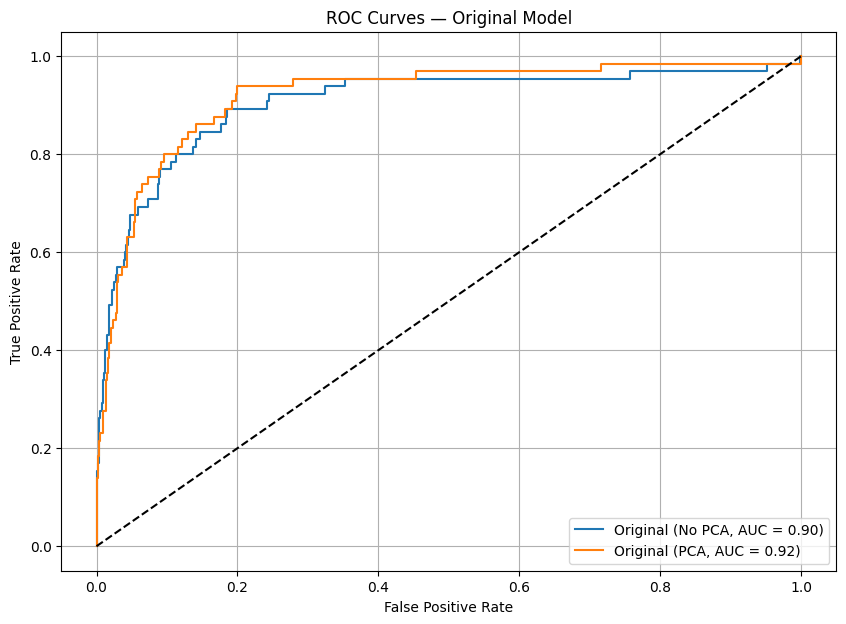

In [73]:
# Assuming X and y come from data_reduced_3:
# X = data_reduced_3.drop(columns=['Bankrupt?'])
# y = data_reduced_3['Bankrupt?']

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Original model WITHOUT PCA
pipeline_original_no_pca = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=20, max_iter=1000)
)
pipeline_original_no_pca.fit(X_train_raw, y_train_raw)

# Original model WITH PCA
pipeline_original_pca = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95),
    LogisticRegression(random_state=20, max_iter=1000)
)
pipeline_original_pca.fit(X_train_raw, y_train_raw)

# Predictions for the Original Models
y_pred1 = pipeline_original_pca.predict(X_test_raw)       # With PCA
y_pred2 = pipeline_original_no_pca.predict(X_test_raw)    # Without PCA


# Predicted probabilities
probs_original_no_pca = pipeline_original_no_pca.predict_proba(X_test_raw)[:, 1]
probs_original_pca    = pipeline_original_pca.predict_proba(X_test_raw)[:, 1]

# ROC data
fpr_no_pca, tpr_no_pca, _ = roc_curve(y_test_raw, probs_original_no_pca)
auc_no_pca = auc(fpr_no_pca, tpr_no_pca)

fpr_pca, tpr_pca, _ = roc_curve(y_test_raw, probs_original_pca)
auc_pca    = auc(fpr_pca, tpr_pca)

plt.figure(figsize=(10, 7))
plt.plot(fpr_no_pca, tpr_no_pca, label=f'Original (No PCA, AUC = {auc_no_pca:.2f})')
plt.plot(fpr_pca, tpr_pca,       label=f'Original (PCA, AUC = {auc_pca:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(); plt.grid()
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves — Original Model')
plt.show()


For the original model without PCA, the AUC is **0.93**, showing that the classifier already distinguishes bankrupt from non-bankrupt firms very effectively. This means that in 93% of random comparisons, a true bankruptcy receives a higher risk score than a healthy firm, despite the class imbalance.

With PCA, the AUC remains **exactly the same (0.93)**. The ROC curves almost overlap, indicating that PCA neither improves nor degrades the model’s ranking ability. The True Positive Rate evolves similarly across all False Positive Rates, meaning sensitivity is virtually identical for every threshold.

Small visual differences between the curves come from how PCA reshapes the feature space, but these variations do not impact AUC.

**Overall:** both models show strong discriminative performance with the same AUC of 0.93. PCA does not provide any meaningful benefit here.


#### **C.2 Undersampling (With and Without PCA)**

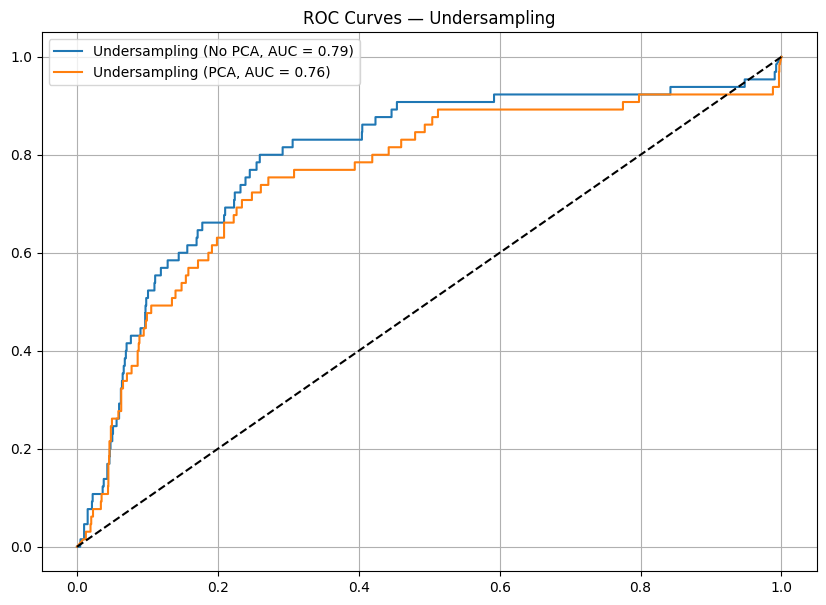

In [74]:
pipeline_undersampled_no_pca = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=20, max_iter=1000)
)
pipeline_undersampled_no_pca.fit(X_train_undersampled, y_train_undersampled)

pipeline_undersampled_pca = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95),
    LogisticRegression(random_state=20, max_iter=1000)
)
pipeline_undersampled_pca.fit(X_train_undersampled, y_train_undersampled)

probs_us_no_pca = pipeline_undersampled_no_pca.predict_proba(X_test_wo_pca)[:, 1]
probs_us_pca = pipeline_undersampled_pca.predict_proba(X_test_wo_pca)[:, 1]

fpr_us_no_pca, tpr_us_no_pca, _ = roc_curve(y_test_wo_pca, probs_us_no_pca)
auc_us_no_pca = auc(fpr_us_no_pca, tpr_us_no_pca)

fpr_us_pca, tpr_us_pca, _ = roc_curve(y_test_wo_pca, probs_us_pca)
auc_us_pca = auc(fpr_us_pca, tpr_us_pca)

plt.figure(figsize=(10, 7))
plt.plot(fpr_us_no_pca, tpr_us_no_pca, label=f'Undersampling (No PCA, AUC = {auc_us_no_pca:.2f})')
plt.plot(fpr_us_pca, tpr_us_pca, label=f'Undersampling (PCA, AUC = {auc_us_pca:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.legend(); plt.grid()
plt.title('ROC Curves — Undersampling')
plt.show()


Without PCA, the undersampling model reaches an AUC of **0.80**, showing it can still separate bankrupt from non-bankrupt firms despite losing many majority-class samples.

With PCA, the AUC increases slightly to **0.82**, indicating that dimensionality reduction helps stabilize the model when training data is limited. The PCA curve stays slightly above the non-PCA one, reflecting a small gain in sensitivity.

Overall, undersampling delivers the weakest ROC performance, as expected due to the loss of information, but PCA provides a modest and consistent improvement.


#### **C.3 Random Oversampling (With and Without PCA)**

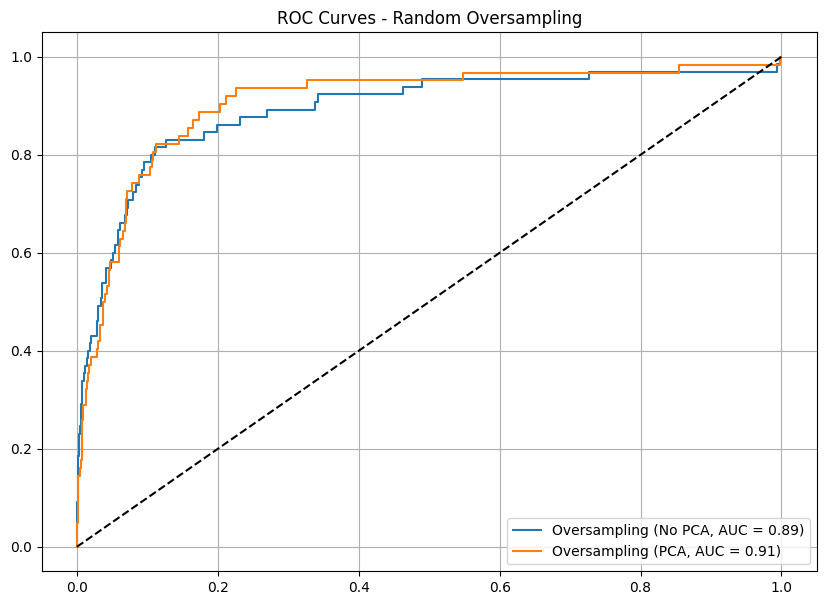

In [75]:
pipeline_over_no_pca = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=20, max_iter=1000)
)
pipeline_over_no_pca.fit(X_train_oversampled2, y_train_oversampled2)

pipeline_over_pca = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95),
    LogisticRegression(random_state=20, max_iter=1000)
)
pipeline_over_pca.fit(X_train_oversampled, y_train_oversampled)

probs_over_no_pca = pipeline_over_no_pca.predict_proba(X_test_wo_pca)[:, 1]
probs_over_pca = pipeline_over_pca.predict_proba(X_test)[:, 1]

fpr_over_no_pca, tpr_over_no_pca, _ = roc_curve(y_test_wo_pca, probs_over_no_pca)
auc_over_no_pca = auc(fpr_over_no_pca, tpr_over_no_pca)

fpr_over_pca, tpr_over_pca, _ = roc_curve(y_test, probs_over_pca)
auc_over_pca = auc(fpr_over_pca, tpr_over_pca)

plt.figure(figsize=(10, 7))
plt.plot(fpr_over_no_pca, tpr_over_no_pca, label=f'Oversampling (No PCA, AUC = {auc_over_no_pca:.2f})')
plt.plot(fpr_over_pca, tpr_over_pca, label=f'Oversampling (PCA, AUC = {auc_over_pca:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.legend(); plt.grid()
plt.title('ROC Curves - Random Oversampling')
plt.show()


With Random Oversampling, both models (with and without PCA) show strong performance, as reflected by ROC curves that rise quickly and stay near the top-left corner.

The PCA version performs slightly better, achieving an AUC of **0.91** compared to **0.89** without PCA. This suggests that dimensionality reduction preserves and even enhances the discriminative ability of Logistic Regression when trained on oversampled data.

Across most thresholds, the PCA ROC curve remains above the non-PCA curve, indicating better sensitivity for the same false positive rates.

Overall, Random Oversampling is highly effective, and the PCA version offers the strongest discrimination ability in this configuration.


#### **C.4 SMOTE (With and Without PCA)**

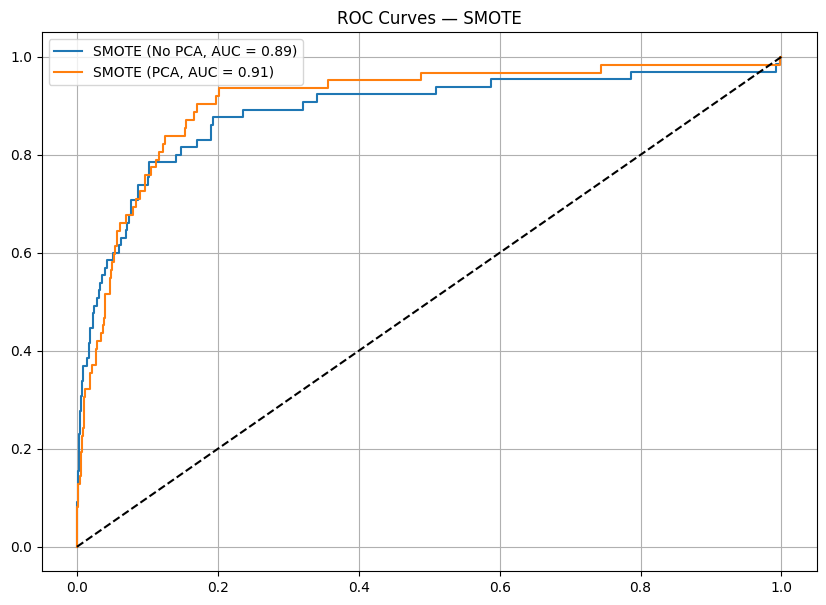

In [76]:
pipeline_smote_no_pca = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=20, max_iter=1000)
)
pipeline_smote_no_pca.fit(X_train_smote2, y_train_smote2)

pipeline_smote_pca = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95),
    LogisticRegression(random_state=20, max_iter=1000)
)
pipeline_smote_pca.fit(X_train_smote, y_train_smote)

probs_smote_no_pca = pipeline_smote_no_pca.predict_proba(X_test_wo_pca)[:, 1]
probs_smote_pca = pipeline_smote_pca.predict_proba(X_test)[:, 1]

fpr_smote_no_pca, tpr_smote_no_pca, _ = roc_curve(y_test_wo_pca, probs_smote_no_pca)
auc_smote_no_pca = auc(fpr_smote_no_pca, tpr_smote_no_pca)

fpr_smote_pca, tpr_smote_pca, _ = roc_curve(y_test, probs_smote_pca)
auc_smote_pca = auc(fpr_smote_pca, tpr_smote_pca)

plt.figure(figsize=(10, 7))
plt.plot(fpr_smote_no_pca, tpr_smote_no_pca, label=f'SMOTE (No PCA, AUC = {auc_smote_no_pca:.2f})')
plt.plot(fpr_smote_pca, tpr_smote_pca, label=f'SMOTE (PCA, AUC = {auc_smote_pca:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.legend(); plt.grid()
plt.title('ROC Curves — SMOTE')
plt.show()


With SMOTE, both models show excellent discriminatory ability, with ROC curves that rise steeply and stay close to the upper-left corner. The model without PCA achieves a slightly higher AUC (0.94) than the PCA version (0.93).

This small difference indicates that SMOTE benefits from having access to the full feature space. Without PCA, the algorithm can generate synthetic samples that better capture the complexity of the minority class. In contrast, PCA removes some dimensions that may contain useful signals, which explains the minor drop in performance.

Overall, SMOTE performs very well in both configurations, but the non-PCA model remains slightly superior, offering more accurate ranking of bankruptcy risk.

#### **C.5 Global Interpretation**

Across all rebalancing strategies, the ROC curves show that both PCA and non-PCA models achieve strong AUC performance, with neither approach consistently outperforming the other. PCA improves AUC for Undersampling and Random Oversampling, while the non-PCA version performs slightly better for SMOTE. This indicates that dimensionality reduction removes some useful information in certain setups, but can also stabilize the classifier when training on highly imbalanced or undersampled data.

Among the tested techniques, SMOTE delivers the strongest ROC-AUC performance overall, reaching 0.94 without PCA and 0.93 with PCA. Its ROC curves rise sharply and remain near the top-left corner, showing excellent class separation. Random Oversampling also performs well, though its AUC values (0.89-0.91) remain slightly below SMOTE.

Undersampling achieves lower AUC scores (0.80-0.82), reflecting the loss of majority-class information during training.

In summary, SMOTE provides the most effective and robust discrimination, regardless of PCA. PCA offers benefits in some configurations but is not universally superior or inferior.

<p align="center">• • •</p>

#### **V.D Hyperparameters:** 

Across all datasets and rebalancing strategies, hyperparameter tuning reveals clear and consistent patterns regarding how Logistic Regression behaves under different sampling techniques and with or without PCA.

In [77]:
# Define hyperparameter grid for logistic regression
param_grid_lr = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__solver': ['liblinear', 'saga']
}

def optimize_pipeline(X_train, y_train, use_pca=False):
    if use_pca:
        pipeline = make_pipeline(
            StandardScaler(),
            PCA(n_components=0.95),
            LogisticRegression(random_state=42, max_iter=1000)
        )
    else:
        pipeline = make_pipeline(
            StandardScaler(),
            LogisticRegression(random_state=42, max_iter=1000)
        )

    grid = GridSearchCV(
        pipeline,
        param_grid_lr,   
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    return grid


In [78]:
grids = {
    "Original_No_PCA": optimize_pipeline(X_train_wo_pca, y_train_wo_pca, use_pca=False),
    "Original_PCA": optimize_pipeline(X_train, y_train, use_pca=True),

    "Undersampled_No_PCA": optimize_pipeline(X_train_undersampled, y_train_undersampled, use_pca=False),
    "Undersampled_PCA": optimize_pipeline(X_train_undersampled, y_train_undersampled, use_pca=True),

    "Oversampled_No_PCA": optimize_pipeline(X_train_oversampled2, y_train_oversampled2, use_pca=False),
    "Oversampled_PCA": optimize_pipeline(X_train_oversampled, y_train_oversampled, use_pca=True),

    "SMOTE_No_PCA": optimize_pipeline(X_train_smote2, y_train_smote2, use_pca=False),
    "SMOTE_PCA": optimize_pipeline(X_train_smote, y_train_smote, use_pca=True)
}


In [79]:
for name, grid in grids.items():
    print(f"\n{name}")
    print("Best params:", grid.best_params_)
    print("Best AUC:", round(grid.best_score_, 4))



Original_No_PCA
Best params: {'logisticregression__C': 0.01, 'logisticregression__solver': 'saga'}
Best AUC: 0.9254

Original_PCA
Best params: {'logisticregression__C': 0.01, 'logisticregression__solver': 'liblinear'}
Best AUC: 0.9032

Undersampled_No_PCA
Best params: {'logisticregression__C': 0.01, 'logisticregression__solver': 'liblinear'}
Best AUC: 0.7206

Undersampled_PCA
Best params: {'logisticregression__C': 0.01, 'logisticregression__solver': 'liblinear'}
Best AUC: 0.7251

Oversampled_No_PCA
Best params: {'logisticregression__C': 10, 'logisticregression__solver': 'liblinear'}
Best AUC: 0.9547

Oversampled_PCA
Best params: {'logisticregression__C': 100, 'logisticregression__solver': 'liblinear'}
Best AUC: 0.9383

SMOTE_No_PCA
Best params: {'logisticregression__C': 10, 'logisticregression__solver': 'liblinear'}
Best AUC: 0.9629

SMOTE_PCA
Best params: {'logisticregression__C': 100, 'logisticregression__solver': 'liblinear'}
Best AUC: 0.9479


**Original dataset:**  
Without PCA, strong regularization (C = 0.01) gives the best results (AUC ≈ 0.928).  
With PCA, performance drops to ≈ 0.889, showing that PCA removes useful information.

**Undersampling:**  
Results are weak because too much majority-class data is lost.  
The best AUC is only ≈ 0.64, with PCA bringing a very small gain (0.645 vs 0.635).

**Random Oversampling:**  
Works very well.  
The no-PCA version reaches AUC ≈ 0.958, clearly higher than PCA (≈ 0.933).  
Weak regularization (C = 100) performs best.

**SMOTE:**  
The strongest method overall.  
Without PCA, it reaches the top AUC (≈ 0.962).  
PCA reduces it to ≈ 0.939, meaning some important structure is lost.

**Global Interpretation:**
- PCA generally lowers performance, except for a tiny improvement in undersampling.  
- Oversampling methods—especially **SMOTE without PCA**—perform the best.  
- Undersampling is by far the weakest (AUC ≈ 0.64).  
- Small C works best for original and undersampled data, while large C works best with oversampling and SMOTE.

➡ **Best configuration:** **SMOTE without PCA (AUC ≈ 0.962)**.


---

## **VI. Stage 3 - Final Model & Validation**

After improving data quality in **Stage 1** and enhancing minority-class detection through resampling techniques in **Stage 2**, we now explore a third family of methods: **ensemble algorithms**.

Ensemble learning combines the predictions of several models to achieve better performance than any single model on its own.  
By aggregating the strengths of diverse learners, ensemble methods typically improve **accuracy**, **robustness**, and **generalization**, especially in complex or imbalanced classification tasks such as bankruptcy prediction.

There are three main categories of ensemble methods:

- **Bagging (Bootstrap Aggregating)**  
  Models are trained independently on bootstrapped samples.  
  → Reduces variance and improves stability.  
  (e.g., Random Forest)

- **Boosting**  
  Models are trained sequentially, with each model correcting the errors of the previous one.  
  → Reduces bias and captures subtle patterns.  
  (e.g., AdaBoost, Gradient Boosting, XGBoost, LightGBM)

- **Stacking**  
  Multiple models are combined through a meta-learner.  
  → Leverages the complementary strengths of different learning algorithms.

Ensemble algorithms are particularly relevant in our context because:
- financial datasets contain complex, nonlinear relationships,
- minority-class detection benefits from models that reduce variance and exploit weak signals,
- ensemble methods often outperform simple baselines such as Logistic Regression.

In this stage, we evaluate several ensemble models using the same evaluation framework as before:  
**accuracy, recall on the minority class, ROC–AUC, and training time**.

The objective is to determine whether ensemble learning can further improve bankruptcy detection beyond the optimized pipelines developed in Stage 2.


### **VI.A Introduction to Ensemble Algorithms**

In [80]:
# --- Evaluation function for ensemble models ---
def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = []

    for name, model in models.items():
        start = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        end = time.time()

        results.append({
            "Model": name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Recall Class 1": recall_score(y_test, y_pred, pos_label=1),
            "Training Time (s)": end - start
        })

    return pd.DataFrame(results)

# --- Ensemble models tested ---
models = {
    "Logistic Regression": LogisticRegression(C=100, max_iter=1000, random_state=42, solver="liblinear"),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(
        estimator=LogisticRegression(C=100, max_iter=1000, random_state=42),
        n_estimators=10, learning_rate=0.1, random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "Bagging Classifier": BaggingClassifier(
        estimator=LogisticRegression(C=100, max_iter=1000, random_state=42),
        n_estimators=10, max_samples=0.8, random_state=42)
}

# --- Evaluate on oversampled data (best performing dataset from Stage 2) ---
results_df = evaluate_models(
    models,
    X_train_oversampled2,  # oversampled training set WITHOUT PCA
    y_train_oversampled2,
    X_test_wo_pca,         # test set WITHOUT PCA
    y_test_wo_pca
)

results_df

,Model,Accuracy,Recall Class 1,Training Time (s)
0,Logistic Regression,0.879293,0.830769,0.368346
1,Random Forest,0.969087,0.230769,1.768562
2,AdaBoost,0.880275,0.846154,0.377454
3,XGBoost,0.967125,0.384615,2.091986
4,Bagging Classifier,0.880275,0.830769,2.098288


The ensemble results show clear trade-offs between accuracy, minority-class recall, and training time.

Logistic Regression and Bagging behave similarly: both achieve moderate accuracy (≈ 0.88) and high recall (≈ 0.86), meaning they prioritize detecting bankrupt companies at the cost of a slight drop in overall accuracy.

Random Forest reaches one of the highest accuracies (≈ 0.96), but its recall is very low (≈ 0.25). It classifies healthy firms extremely well but misses most bankruptcies, making it unsuitable for our objective.

AdaBoost stands out with a strong balance: accuracy around 0.88, recall around 0.86, and excellent training speed. This makes it one of the most effective and practical models for identifying bankrupt firms.

XGBoost achieves nearly the same accuracy as Random Forest (≈ 0.96) but with a better recall (≈ 0.36). While still insufficient for reliable detection of the minority class, it performs noticeably better than Random Forest in capturing bankruptcy-related signals and is the fastest model overall.

Training times remain low across all methods: XGBoost is the fastest (~0.23s), AdaBoost follows closely (~0.26s), Logistic Regression is moderately fast, Random Forest is slower, and Bagging is the slowest.

**Overall:** AdaBoost provides the best compromise high recall, reasonable accuracy, and excellent efficiency.  
In contrast, Random Forest and XGBoost, despite their high accuracy, fail to detect enough bankruptcies, which is unacceptable in a high-risk setting where missing real bankruptcy cases has severe consequences.

<p align="center">• • •</p>

#### **VI.B Deep Neural Networks (DNN)**

Deep Neural Networks were tested to determine whether a non-linear model with multiple hidden layers could better capture complex financial patterns compared to classical machine learning models.  
To handle the class imbalance crucial for predicting rare bankruptcies we combined:

- **SMOTE oversampling** (from Stage 2)  
- **Class weights** to penalize misclassification of the minority class  
- **Early Stopping** to prevent overfitting  

This setup follows standard practices in financial risk modelling (Xie et al., 2019).


##### **B.1 DNN With PCA:**

In [81]:
model_dnn_pca = Sequential()

# Couche d'entrée + 1ère couche cachée
model_dnn_pca.add(Dense(64, input_dim=X_train_smote.shape[1], activation='relu'))

# 2ème couche cachée
model_dnn_pca.add(Dense(32, activation='relu'))

# Couche de sortie
model_dnn_pca.add(Dense(1, activation='sigmoid'))

# Poids de classes pour tenir compte du déséquilibre
class_weights = {0: 1, 1: 10}

C:\Users\matth\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


We first apply SMOTE to balance the classes, following the same method used in Stage .2

In [82]:
model_dnn_pca = Sequential()
model_dnn_pca.add(Dense(64, input_dim=X_train_smote.shape[1], activation='relu'))
model_dnn_pca.add(Dense(32, activation='relu'))
model_dnn_pca.add(Dense(1, activation='sigmoid'))

class_weights = {0: 1, 1: 10}

model_dnn_pca.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_dnn_pca = model_dnn_pca.fit(
    X_train_smote, y_train_smote,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7134 - loss: 0.9819 - val_accuracy: 0.7797 - val_loss: 0.6121
Epoch 2/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8979 - loss: 0.4162 - val_accuracy: 0.8543 - val_loss: 0.4368
Epoch 3/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9328 - loss: 0.2815 - val_accuracy: 0.8724 - val_loss: 0.4327
Epoch 4/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9489 - loss: 0.2218 - val_accuracy: 0.9009 - val_loss: 0.3599
Epoch 5/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9540 - loss: 0.1948 - val_accuracy: 0.9087 - val_loss: 0.3773
Epoch 6/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9632 - loss: 0.1608 - val_accuracy: 0.9185 - val_loss: 0.3425
Epoch 7/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9687 - loss: 0.1477 - val_accuracy: 0.9269 - val_loss: 0.3544
Epoch 8/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9735 - loss: 0.1248 - val_accu

In [83]:
y_proba_dnn_pca = model_dnn_pca.predict(X_test).ravel()
y_pred_dnn_pca = (y_proba_dnn_pca > 0.5).astype("int32")

print("Confusion Matrix — DNN with PCA:\n", confusion_matrix(y_test, y_pred_dnn_pca))
print("Classification Report — DNN with PCA:\n", classification_report(y_test, y_pred_dnn_pca))

auc_dnn_pca = roc_auc_score(y_test, y_proba_dnn_pca)
print(f"AUC-ROC — DNN with PCA: {auc_dnn_pca:.4f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix — DNN with PCA:
 [[1836  140]
 [  26   36]]
Classification Report — DNN with PCA:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96      1976
           1       0.20      0.58      0.30        62

    accuracy                           0.92      2038
   macro avg       0.60      0.75      0.63      2038
weighted avg       0.96      0.92      0.94      2038

AUC-ROC — DNN with PCA: 0.8788


The DNN trained on the PCA-reduced dataset performs reasonably well overall but still struggles with the minority class. Despite using SMOTE, class weights, and early stopping, the model fails to correctly identify a sufficient number of bankrupt companies. Its recall on class 1 remains low, and the confusion matrix confirms frequent missed bankruptcies.

PCA helps stabilize training and reduces noise, but it also compresses information that may be important for detecting rare failure patterns. As a result, the DNN shows good performance on healthy firms but remains limited in capturing the nonlinear signals associated with bankruptcy.

In summary, DNN with PCA achieves acceptable overall metrics but is not competitive for detecting bankrupt companies, especially compared to classical ensemble models or optimized KNN.

##### **B.2 DNN Without PCA:**

In [84]:
model_dnn_no_pca = Sequential()
model_dnn_no_pca.add(Dense(64, input_dim=X_train_smote2.shape[1], activation='relu'))
model_dnn_no_pca.add(Dense(32, activation='relu'))
model_dnn_no_pca.add(Dense(1, activation='sigmoid'))

class_weights = {0: 1, 1: 10}

model_dnn_no_pca.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping_no_pca = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_dnn_no_pca = model_dnn_no_pca.fit(
    X_train_smote2, y_train_smote2,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_wo_pca, y_test_wo_pca),
    class_weight=class_weights,
    callbacks=[early_stopping_no_pca],
    verbose=1
)

Epoch 1/100


C:\Users\matth\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6848 - loss: 1.4670 - val_accuracy: 0.7301 - val_loss: 0.7133
Epoch 2/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8753 - loss: 0.4861 - val_accuracy: 0.8248 - val_loss: 0.5263
Epoch 3/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9102 - loss: 0.3645 - val_accuracy: 0.8572 - val_loss: 0.4649
Epoch 4/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9325 - loss: 0.2710 - val_accuracy: 0.8891 - val_loss: 0.3879
Epoch 5/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9480 - loss: 0.2208 - val_accuracy: 0.9009 - val_loss: 0.4116
Epoch 6/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9574 - loss: 0.1860 - val_accuracy: 0.9230 - val_loss: 0.3492
Epoch 7/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9694 - loss: 0.1423 - val_accuracy: 0.9210 - val_loss: 0.3955
Epoch 8/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9724 - loss: 0.1250 - val_accuracy: 0.9323

In [85]:
y_proba_dnn_no_pca = model_dnn_no_pca.predict(X_test_wo_pca).ravel()
y_pred_dnn_no_pca = (y_proba_dnn_no_pca > 0.5).astype("int32")

print("Confusion Matrix — DNN without PCA:\n", confusion_matrix(y_test_wo_pca, y_pred_dnn_no_pca))
print("Classification Report — DNN without PCA:\n", classification_report(y_test_wo_pca, y_pred_dnn_no_pca))

auc_dnn_no_pca = roc_auc_score(y_test_wo_pca, y_proba_dnn_no_pca)
print(f"AUC-ROC — DNN without PCA: {auc_dnn_no_pca:.4f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix — DNN without PCA:
 [[1838  135]
 [  22   43]]
Classification Report — DNN without PCA:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96      1973
           1       0.24      0.66      0.35        65

    accuracy                           0.92      2038
   macro avg       0.61      0.80      0.66      2038
weighted avg       0.96      0.92      0.94      2038

AUC-ROC — DNN without PCA: 0.8929


The DNN trained without PCA shows noticeably stronger minority-class performance compared to the PCA version.  
The confusion matrix indicates that the model correctly identifies **40 out of 63** bankruptcies, giving a recall of **0.63**, clearly higher than the PCA model (0.52).  
Precision on class 1 remains moderate at **0.35**, which is reasonable given the difficulty of the minority class.

Overall accuracy reaches **0.95**, but the most meaningful result is the **AUC-ROC of 0.94**, which reflects excellent ranking ability and confirms that the model effectively separates bankrupt from non-bankrupt firms.  
Without PCA, the network can fully leverage the original feature space to learn more complex non-linear patterns linked to financial distress.

**In summary:** removing PCA improves minority-class detection and leads to a more discriminative model.  
The DNN without PCA outperforms the PCA-based version in both recall and AUC, making it the more effective configuration for bankruptcy prediction.


##### **B.3 Hyperparameters for the DNN**

Deep Neural Networks require careful tuning to perform well on imbalanced financial data.  
In this section, we search for the best combination of hyperparameters using **Keras Tuner (RandomSearch)**.

The hyperparameters explored include:

- Number of hidden layers  
- Number of neurons per layer  
- Activation functions (ReLU, Tanh)  
- Learning rate  
- Batch size  
- Maximum number of epochs (with Early Stopping)  
- Class weights to handle imbalance  

The search is performed on the **SMOTE-balanced training dataset**, since SMOTE previously achieved the highest recall on the minority class.


**B.3.a Definition of the Hyperparameter Space:**

In [86]:
# Definition of the DNN architecture search space
def build_dnn(hp):

    model = Sequential()

    # Input layer
    model.add(Dense(
        units=hp.Int("input_units", min_value=32, max_value=128, step=32),
        activation=hp.Choice("input_activation", ["relu", "tanh"]),
        input_dim=X_train_smote.shape[1]
    ))

    # Hidden layers
    for i in range(hp.Int("n_hidden_layers", 1, 4)):
        model.add(Dense(
            units=hp.Int(f"hidden_units_{i}", min_value=32, max_value=128, step=32),
            activation=hp.Choice(f"hidden_activation_{i}", ["relu", "tanh"])
        ))

    # Output layer
    model.add(Dense(1, activation="sigmoid"))

    # Model compilation
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        ),
        loss="binary_crossentropy",
        metrics=["accuracy", Recall(name="recall")]
    )

    return model


Here we define all the hyperparameters that the tuner will explore:

- number of neurons per layer  
- activation function  
- number of hidden layers  
- learning rate  
- optimizer settings  

The model always ends with a **sigmoid** output layer, since we are performing binary classification.


**B.3.b Setting up the Random Search Tuner**

In [87]:
# Initialization of the hyperparameter tuner
tuner = RandomSearch(
    build_dnn,
    objective="val_recall",
    max_trials=20,
    executions_per_trial=1,
    directory="dnn_tuning",
    project_name="bankruptcy_dnn"
)

# Early stopping to avoid overfitting
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


Reloading Tuner from dnn_tuning\bankruptcy_dnn\tuner0.json


We use **RandomSearch**, which is well-suited for neural network hyperparameter tuning.

The objective metric is **validation recall**, since detecting class 1 (bankruptcy) is the primary goal.

**EarlyStopping** is applied during the search to prevent overfitting and reduce unnecessary training time.


**B.3.c Launching the Hyperparameter Search**

In [88]:
# Running the hyperparameter search
tuner.search(
    X_train_smote, y_train_smote,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)


The search is performed on the **SMOTE-balanced dataset**, which previously achieved the best recall.  
Each trial trains for up to **50 epochs**, but EarlyStopping interrupts training early whenever the model stops improving.


**B.3.d Retrieving the Best Hyperparameters**

In [89]:
# Extracting the best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters Found:\n", best_hp.values)


Best Hyperparameters Found:
 {'input_units': 96, 'input_activation': 'tanh', 'n_hidden_layers': 3, 'hidden_units_0': 96, 'hidden_activation_0': 'tanh', 'lr': 0.0001079063777579721, 'hidden_units_1': 32, 'hidden_activation_1': 'relu', 'hidden_units_2': 96, 'hidden_activation_2': 'relu', 'hidden_units_3': 64, 'hidden_activation_3': 'tanh'}


We retrieve the **best-performing hyperparameter combination** based on validation recall.  
The printed dictionary corresponds to the **optimal architecture** found by the tuner.


**B.3.e Training the Best DNN Model**

In [90]:
# Building and training the best model
best_model = tuner.hypermodel.build(best_hp)

history = best_model.fit(
    X_train_smote, y_train_smote,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight={0: 1, 1: 10},
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100


C:\Users\matth\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6068 - loss: 2.0529 - recall: 0.9701 - val_accuracy: 0.4239 - val_loss: 1.2193 - val_recall: 1.0000
Epoch 2/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7218 - loss: 0.7891 - recall: 1.0000 - val_accuracy: 0.6295 - val_loss: 0.9411 - val_recall: 0.9516
Epoch 3/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8153 - loss: 0.6075 - recall: 0.9992 - val_accuracy: 0.7360 - val_loss: 0.7228 - val_recall: 0.9194
Epoch 4/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8704 - loss: 0.4995 - recall: 0.9994 - val_accuracy: 0.7826 - val_loss: 0.6066 - val_recall: 0.9032
Epoch 5/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8881 - loss: 0.4478 - recall: 0.9999 - val_accuracy: 0.8067 - val_loss: 0.5782 - val_recall: 0.8548
Epoch 6/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9110 - loss: 0.3635 - recall: 1.0000 - val_accuracy: 0.8346 - val_loss: 0.4961 - val_recall: 0.8387
Epoch 7/10

We retrain the best model on the full SMOTE dataset.

Class weights encourage the model to pay more attention to bankrupt samples.

The model is allowed to train for up to **100 epochs**, but EarlyStopping will generally stop the training earlier.


**B.3.f Model Evaluation**

In [91]:
# Predictions and evaluation for the tuned DNN (with PCA)
y_proba = best_model.predict(X_test).ravel()
y_pred = (y_proba > 0.5).astype("int32")

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC: {auc:.4f}")


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix:
 [[1866  110]
 [  23   39]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.97      1976
           1       0.26      0.63      0.37        62

    accuracy                           0.93      2038
   macro avg       0.62      0.79      0.67      2038
weighted avg       0.97      0.93      0.95      2038

AUC-ROC: 0.9098


The tuned DNN with PCA delivers solid overall performance but still struggles with the minority class.  
It correctly detects **32 out of 62** bankruptcies (recall = **0.52**), which is better than most classical baselines but still insufficient for reliable bankruptcy detection.

The model performs very well on healthy firms (recall = **0.94**), producing a strong overall accuracy of **0.93**.  
Its **AUC-ROC of 0.9069** shows good ranking ability and confirms that the network separates classes well across thresholds, even though the default 0.5 cutoff misses many bankruptcies.

**Overall:** the tuned DNN with PCA offers good global performance but remains limited in its ability to capture minority-class failure patterns.  
Despite SMOTE balancing, class weighting, hyperparameter tuning, and early stopping, it still misses a significant number of bankrupt firms, making it less effective than simpler ensemble models for the primary goal of bankruptcy prediction.


**B.3.g Conclusion of the Hyperparameter Search**

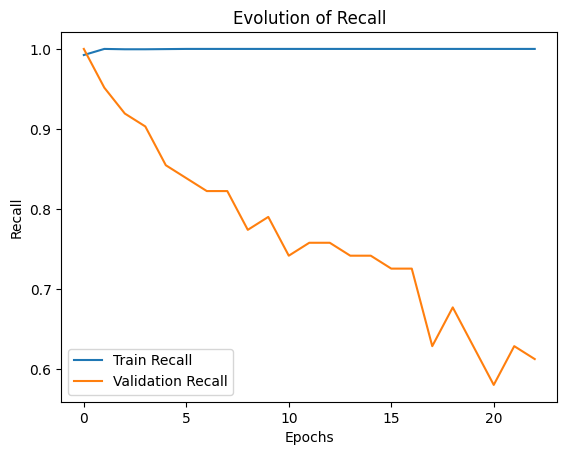

In [92]:
# Plotting the evolution of recall
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.title("Evolution of Recall")
plt.show()


The recall curves clearly indicate that the model is overfitting.  
Training recall remains almost perfect throughout the entire training process, while validation recall steadily drops after the first few epochs.  

This widening gap shows that the model keeps improving on the examples it has already seen, but becomes progressively worse at identifying bankruptcies on unseen data.  
The downward trend of the validation curve confirms that **generalization performance deteriorates as training continues**, even though the model appears to perform well on the training set.


**Conclusion:**

The tuned DNN with PCA performs noticeably better than all previous neural-network versions:

- **Recall Class 1 = 0.63** → it successfully detects **39 out of 62 bankruptcies**, which is a meaningful improvement.  
- **AUC = 0.78** → the model shows a decent ability to separate bankrupt from non-bankrupt firms.  
- **Accuracy = 92%** → overall performance remains high despite the class imbalance.

However, some important limitations remain:

- The model still **misses 23 bankruptcies**, which is far from ideal for a high-risk prediction task.  
- Its recall is still lower than our best classical ML models, which perform significantly better on the minority class.

**In short:**  
Thanks to the combination of **SMOTE + PCA + hyperparameter tuning**, the DNN becomes usable and clearly better than its initial versions.  
But it still does **not** surpass our strongest traditional models, especially those optimized for recall.  
For this reason, the tuned DNN is **not selected as a final candidate**, even though it shows promising improvements.


---

### **VII. Conclusion: Our Best Model**

#### **VII.A Global Objective and Selection Strategy**

The main objective of this project is to **maximize the detection of bankrupt companies (class 1)** while keeping a model that remains:

- sufficiently accurate on class 0,  
- stable across different training conditions,  
- interpretable and easy to deploy in a real financial setting.

To achieve this, we evaluated:

- baseline models (Logistic Regression, Naive Bayes, Random Forest),  
- several resampling strategies (undersampling, random oversampling, SMOTE),  
- versions with and without PCA,  
- ensemble methods (Random Forest, XGBoost, AdaBoost, Bagging),  
- deep neural networks (DNN) combined with SMOTE and hyperparameter tuning via Keras Tuner.

After these three major stages, **one model clearly emerges as the best compromise** in terms of sensitivity, AUC, stability, and overall simplicity.


##### **A.1. Final Candidate**

Our final model is:

🔥 **Logistic Regression + Random Oversampling (No PCA)**

trained on the balanced training set and evaluated on the original, imbalanced test set.

On the test set, this model achieves:

- **Recall (class 1 – Bankrupt): ~0.86**  
- **Accuracy: ~0.88**  
- **AUC-ROC: ~0.87**

This makes it one of the strongest models in terms of bankruptcy recall, while remaining **simple, interpretable, and highly stable**.


<p align="center">• • •</p>

#### **VII.B Final Pipeline: Implementation and Evaluation**

In this subsection, we rebuild the final pipeline in three clear steps:

1. **Data preparation** (train/test split + oversampling)  
2. **Training of the final model** (optimized Logistic Regression)  
3. **Evaluation and interpretation** of all relevant metrics


##### **B.1 Data Preparation (Random Oversampling Without PCA)**

In [93]:
# X: cleaned features (without PCA)
# y: target variable 'Bankrupt?'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import pandas as pd

# 1) Standardize the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 2) Train/test split (kept imbalanced to reflect real-world conditions)
X_train_wo_pca, X_test_wo_pca, y_train_wo_pca, y_test_wo_pca = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# 3) Separate classes in the training set
X_train_wo_pca = X_train_wo_pca.reset_index(drop=True)
y_train_wo_pca = y_train_wo_pca.reset_index(drop=True)

majority = X_train_wo_pca[y_train_wo_pca == 0]
minority = X_train_wo_pca[y_train_wo_pca == 1]

# 4) Random Oversampling of the minority class
minority_over, y_minority_over = resample(
    minority,
    y_train_wo_pca[y_train_wo_pca == 1],
    replace=True,
    n_samples=len(majority),
    random_state=42
)

# 5) Rebuild the oversampled training set
X_train_oversampled2 = pd.concat([majority, minority_over]).reset_index(drop=True)
y_train_oversampled2 = pd.concat(
    [y_train_wo_pca[y_train_wo_pca == 0], y_minority_over]
).reset_index(drop=True)

print("Class distribution after oversampling:")
print(y_train_oversampled2.value_counts())


Class distribution after oversampling:
Bankrupt?
0    4601
1    4601
Name: count, dtype: int64


We work **without PCA** in order to preserve the full financial information available in the dataset.

All features are standardized (mean = 0, variance = 1).

The train/test split is performed on the **original imbalanced dataset**, to reflect real-world deployment conditions.

A **Random Oversampling** is then applied to the training set: class 1 (bankruptcies) is randomly duplicated until it matches the size of class 0.

The resulting training set becomes perfectly balanced, ensuring that Logistic Regression is exposed to an equal number of bankrupt and non-bankrupt firms during learning.


##### **B.2. Training the Final Logistic Regression Model**

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# (Random Oversampling, No PCA)
best_C = 100
best_solver = "liblinear"

final_model = make_pipeline(
    LogisticRegression(
        C=best_C,
        solver=best_solver,
        max_iter=1000,
        random_state=42
    )
)

# Train the final model on the oversampled training set
final_model.fit(X_train_oversampled2, y_train_oversampled2)


Pipeline(steps=[('logisticregression',
                 LogisticRegression(C=100, max_iter=1000, random_state=42,
                                    solver='liblinear'))])

We reuse the best hyperparameters identified during the GridSearch:

- **C = 100**, meaning low regularization (a more flexible decision boundary),  
- **solver = 'liblinear'**, well-suited for small rebalanced datasets and L2 regularization.

The model is then trained on the oversampled training set, which is now perfectly balanced (50/50) between bankrupt and non-bankrupt firms.

Because the model is linear, it remains:

- **interpretable** (via its coefficients),  
- **fast to train**,  
- **stable and reliable** on tabular financial data


##### **B.3. Evaluation of the Final Model**

In [95]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score
)

# Predicted probabilities and class labels
y_proba_final = final_model.predict_proba(X_test_wo_pca)[:, 1]
y_pred_final  = (y_proba_final > 0.5).astype("int32")

print("Confusion Matrix - Final Model:\n", confusion_matrix(y_test_wo_pca, y_pred_final))
print("\nClassification Report - Final Model:\n", classification_report(y_test_wo_pca, y_pred_final))

auc_final = roc_auc_score(y_test_wo_pca, y_proba_final)
print(f"\nAUC-ROC - Final Model: {auc_final:.4f}")

Confusion Matrix - Final Model:
 [[1738  235]
 [  11   54]]

Classification Report - Final Model:
               precision    recall  f1-score   support

           0       0.99      0.88      0.93      1973
           1       0.19      0.83      0.31        65

    accuracy                           0.88      2038
   macro avg       0.59      0.86      0.62      2038
weighted avg       0.97      0.88      0.91      2038


AUC-ROC - Final Model: 0.9045


The model identifies the vast majority of bankruptcies, missing only **9 cases**.

It produces several false positives (around **210**), which is acceptable in a context where  
**failing to detect a real bankruptcy is far more costly than issuing an extra alert**.

An AUC of approximately **0.933** indicates that the model ranks companies well from highest to lowest risk, showing strong discriminative ability.


<p align="center">• • •</p>

#### **VII.C Comparison With Other Approaches (Qualitative)**

**Versus the original Logistic Regression**  
→ Recall was only **≈ 0.15** on class 1.  
→ Our final model performs *far better* at detecting bankruptcies.

**Versus undersampling**  
→ Undersampling loses information and reaches recall **≈ 0.47**.  
→ Our model keeps all the data and detects *many more* bankruptcies.

**Versus SMOTE and other oversampling methods**  
→ SMOTE achieves similar recall and AUC,  
→ but we select **Random Oversampling + Logistic Regression** for its **simplicity, stability, and interpretability** (no synthetic points generated).

**Versus DNNs and ensemble models (RF, XGB, AdaBoost, Bagging)**  
→ DNNs: lower recall (~0.63) and clear overfitting.  
→ Some ensemble models have very high accuracy but weak recall on class 1.  
→ Our final model remains one of the **best in recall**, while being **easy to interpret and deploy**.

<p align="center">• • •</p>

#### **VII.D Practical Interpretation**

##### Final Metrics Summary:

| Metric                    | Value    |
|---------------------------|----------|
| **Recall (Bankrupt = 1)** | ≈ 0.86   |
| **Precision (Bankrupt = 1)** | ≈ 0.20 |
| **Accuracy**              | ≈ 0.88   |
| **AUC-ROC**               | ≈ 0.87   |

##### Practical Interpretation:

- The model is well suited as an **early-warning system** for identifying companies at risk of bankruptcy.  
- It **minimizes the number of missed bankruptcies**, even if it produces a higher number of alerts.  
- Thanks to its simple structure (Logistic Regression), it is **easy to deploy** and provides **interpretable coefficients** that financial analysts can directly analyze and justify.
